In [436]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymaid
import logging
import random
from graspologic.match import graph_match
from graspologic.simulations import er_np
from graspologic.utils import is_unweighted
from numpy.random import default_rng
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations_v2, load_connectome_normal_lcc_annotations_v3, load_connectome_lcc_normal_adj, load_left_adj, load_right_adj, load_left_adj_labels_with_class_v2, load_right_adj_labels_with_class_v2, load_head_adj_labels_with_class_v2, load_pygidium_adj_labels_with_class_v2, load_0_adj, load_1_adj_labels_with_class_v2, load_2_adj_labels_with_class_v2, load_3_adj_labels_with_class_v2, load_left_adj_labels_with_class_v3, load_right_adj_labels_with_class_v3

In [ ]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

Grab Nadine's pairs: these are the true pairs

In [ ]:
folder = "/Users/kareefullah/Desktop/naomi-pairwise.xlsx"
true_df = pd.read_excel(folder, dtype=str)

#need to subset true_pairs for the pairs that have left and right entries in their row
true_pairs = true_df[["skid-ID LEFT", "skid-ID RIGHT"]]

#subset true_pairs to not include pairs of neurons that do not have a match
true_pairs = true_pairs[~true_pairs.isnull().any(axis=1)].reset_index()
left_true = list(true_pairs["skid-ID LEFT"])
right_true = list(true_pairs["skid-ID RIGHT"])
true_pairs

Load in the left and right adjacency matrices (each neuron in both adjacencies has an associated class label)

In [ ]:
left_adj, left_labels = load_left_adj_labels_with_class_v3()
right_adj, right_labels = load_right_adj_labels_with_class_v3()

np_left_adj = np.array(left_adj)
np_right_adj = np.array(right_adj)

np_left_labels = np.array(left_labels)
np_right_labels = np.array(right_labels)

left_skids = np.array(left_adj.index)
right_skids = np.array(right_adj.index)

n_iters = 3
n_iters_rand = 100

print(len(left_adj))
print(len(right_adj))

In [ ]:
sub_left_skids = [skid for skid in left_skids if skid in left_true]
sub_right_skids = [skid for skid in right_skids if skid in right_true]

sub_left_skids = np.array(sub_left_skids)
sub_right_skids = np.array(sub_right_skids)

#find the inds from left and right skid lists that are in the respective subgraphs
left_inds = [i for i, e in enumerate(left_skids) if e in sub_left_skids]
right_inds = [i for i, e in enumerate(right_skids) if e in sub_right_skids]

#grab the subset of labels from the ind lists
sub_left_labels = np_left_labels[left_inds]
sub_right_labels = np_left_labels[right_inds]

We begin by initializing the whole/sub adjacencies by permuting the skids based on whether the skids are in Nadine's list or not

In [ ]:
def init_skids_and_adjs(type="whole", n_iters=10):
    """
    This function modifies the left and right skid lists such that the skids that are paired in Nadine's lists are moved to the front of their
    respective lists and aligned, while the other skids moved after these skids. We also permute the neurons' respective labels accordingly.
    After constructing these permuted skid lists, we extract adjacencies from them.

    Args:
        type: (str, optional): 
            "whole": use the whole skid lists and labels.
            "sub": use the sub skid lists and labels. 
            Defaults to "whole".

        n_iters (int, optional):
            Number of times to make skid lists. This is necessary because there exists randomness in the skids from the left list
            that are chopped off in order for the dimensions to match. Defaults to 10.
    
    Returns:
        values: (dict):
            "left_adj_list": the initialized list of left adjs. Length of n_iters.
            "right_adj_list": the initialized list of right adjs. Length of n_iters.
            "left_skids_to_match_list": the initialized list of left skids. Length of n_iters.
            "right_skids_to_match_list": the initialized list of right skids. Length of n_iters.
            "num_pairs": the number of pairs in our skid lists that existed in Nadine's list.
            "left_labels_perm_list": the permuted list of left labels. Length of n_iters.
            "right_labels_perm_list": the permuted list of right labels. Length of n_iters.
            "class_sim_mat_list": the class similarity matrix list of each left and right label pair. Length of n_iters.
            "nadine_pairs_list": the list of dataframes of our initialized left and right skids. Length of n_iters.
    """

    if(type=="whole"):

        #the original skid lists
        left_skids_to_use = left_skids.copy()
        right_skids_to_use = right_skids.copy()

        #the original labels
        left_labels_to_use = np_left_labels.copy()
        right_labels_to_use = np_right_labels.copy()

    elif(type=="sub"):
        left_skids_to_use = sub_left_skids.copy()
        right_skids_to_use = sub_right_skids.copy()

        left_labels_to_use = sub_left_labels.copy()
        right_labels_to_use = sub_right_labels.copy()

    else:
        return
    
    #these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
    left_skids_in_pairs = []
    right_skids_in_pairs = []

    #need to save the indices where in which the skids of the original lists are permuted so we can permute the labels respectively
    left_inds_pairs_permuted = []
    right_inds_pairs_permuted = []

    #iterate through Nadine's list
    for i in range(len(true_pairs)):

        #find the pairs in Nadine's lists in which both neurons are in our left and right lists respectively
        if (true_pairs.loc[i, "skid-ID LEFT"] in left_skids_to_use and true_pairs.loc[i, "skid-ID RIGHT"] in right_skids_to_use):
            left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
            right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

            #find the inds in our left and right skids lists where these neurons in Nadine's pair exist, need the inds to permute our labels
            left_ind = np.where(left_skids_to_use == true_pairs.loc[i, "skid-ID LEFT"])[0][0]
            right_ind = np.where(right_skids_to_use == true_pairs.loc[i, "skid-ID RIGHT"])[0][0]
            left_inds_pairs_permuted.append(left_ind)
            right_inds_pairs_permuted.append(right_ind)

    #num_pairs is the length of either the left or right skids in pairs list
    num_pairs = len(left_skids_in_pairs)

    #get the list of skids in our left and right skids that are not in the lists we just made and shuffle them: need to do this multiple times because the left neurons that are dropped are random
    left_skids_not_pairs_list = []
    right_skids_not_pairs_list = []
    left_inds_not_pairs_list = []
    right_inds_not_pairs_list = []

    rng = default_rng()

    #iterate through left skids
    for i in range(n_iters):

        left_skids_not_pairs = []
        left_inds_not_pairs = []
        for j in range(len(left_skids_to_use)):
            if(left_skids_to_use[j] not in left_skids_in_pairs):
                left_skids_not_pairs.append(left_skids_to_use[j])
                
                #get the ind where these non paired neurons occur
                left_ind = np.where(left_skids_to_use == left_skids_to_use[j])[0][0]
                left_inds_not_pairs.append(left_ind)

        #iterate through right skids 
        right_skids_not_pairs = []
        right_inds_not_pairs = []
        for j in range(len(right_skids_to_use)):
            if(right_skids_to_use[j] not in right_skids_in_pairs):
                right_skids_not_pairs.append(right_skids_to_use[j])
                
                #get the ind where these non paired neurons occur
                right_ind = np.where(right_skids_to_use == right_skids_to_use[j])[0][0]
                right_inds_not_pairs.append(right_ind)
        
        #shuffle the lists to introduce randomization of which left skids get discarded
        left_skids_not_pairs = np.array(left_skids_not_pairs)
        right_skids_not_pairs = np.array(right_skids_not_pairs)
        left_inds_not_pairs = np.array(left_inds_not_pairs)
        right_inds_not_pairs = np.array(right_inds_not_pairs)

        #randomize the skids
        rand_ind_left = rng.choice(len(left_skids_not_pairs), size=len(left_skids_not_pairs), replace=False)
        left_skids_not_pairs_rand = left_skids_not_pairs[rand_ind_left]
        left_skids_not_pairs_list.append(left_skids_not_pairs_rand)

        #update the corresponding inds
        left_inds_not_pairs_rand = left_inds_not_pairs[rand_ind_left]
        left_inds_not_pairs_list.append(left_inds_not_pairs_rand)

        #randomize the skids
        rand_ind_right = rng.choice(len(right_skids_not_pairs), size=len(right_skids_not_pairs), replace=False)
        right_skids_not_pairs_rand = right_skids_not_pairs[rand_ind_right]
        right_skids_not_pairs_list.append(right_skids_not_pairs_rand)

        #update the corresponding inds
        right_inds_not_pairs_rand = right_inds_not_pairs[rand_ind_right]
        right_inds_not_pairs_list.append(right_inds_not_pairs_rand)

    left_skids_to_match_list = []
    right_skids_to_match_list = []
    left_inds_permuted_list = []
    right_inds_permuted_list = []

    #make n_iters number of lists of left and right skids and inds through concatenating
    for i in range(n_iters):
        left_skids_to_match = np.append(left_skids_in_pairs, left_skids_not_pairs_list[i], axis=0)
        right_skids_to_match = np.append(right_skids_in_pairs, right_skids_not_pairs_list[i], axis=0)
        left_inds_permuted = np.append(left_inds_pairs_permuted, left_inds_not_pairs_list[i], axis=0)
        right_inds_permuted = np.append(right_inds_pairs_permuted, right_inds_not_pairs_list[i], axis=0)

        left_skids_to_match_list.append(left_skids_to_match)
        right_skids_to_match_list.append(right_skids_to_match)
        left_inds_permuted_list.append(left_inds_permuted)
        right_inds_permuted_list.append(right_inds_permuted)
        
    left_skids_to_match_list = np.array(left_skids_to_match_list)
    right_skids_to_match_list = np.array(right_skids_to_match_list)
    left_inds_permuted_list = np.array(left_inds_permuted_list)
    right_inds_permuted_list = np.array(right_inds_permuted_list)

    #permute the labels of the neurons based on how the skids were permuted
    #NOTE: Need to modify length of left labels because the skids will be cut to the length of the right skids list length
    right_labels_perm_list = []
    left_labels_perm_list = []
    for i in range(n_iters):
        right_labels_perm = right_labels_to_use[right_inds_permuted_list[i]]
        left_labels_perm = left_labels_to_use[left_inds_permuted_list[i]][0:len(right_labels_perm)]

        right_labels_perm_list.append(right_labels_perm)
        left_labels_perm_list.append(left_labels_perm)
    
    #make class similarity matrices using the permuted labels
    class_sim_mat_list = []
    for i in range(n_iters):
        class_sim_mat = left_labels_perm_list[i][:, None] == right_labels_perm_list[i][None, :]
        class_sim_mat_list.append(class_sim_mat)


    #CAVEAT: Some of the last skids of the left list are removed so that the dimensions match in the dataframe
    #NOTE: This is ok because the last skids of the left list are not paired because of how we initalized the skid lists
    nadine_pairs_list = []
    for i in range(n_iters):
        nadine_pairs = pd.DataFrame(list(zip(left_skids_to_match_list[i], right_skids_to_match_list[i])), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
        nadine_pairs_list.append(nadine_pairs)

    #Generate the adjs
    left_adj_list = []
    right_adj_list = []
    for i in range(n_iters):
        #grab the skids from the dataframe (ensures the dimensions match)
        left_adj_skids = list(nadine_pairs["skid-ID LEFT"])
        right_adj_skids = list(nadine_pairs["skid-ID RIGHT"])

        #generate the adjs
        left_adj_induced = pymaid.adjacency_matrix(left_adj_skids)
        right_adj_induced = pymaid.adjacency_matrix(right_adj_skids)

        np_left_adj_induced = np.array(left_adj_induced)
        np_right_adj_induced = np.array(right_adj_induced)
        
        left_adj_list.append(np_left_adj_induced)
        right_adj_list.append(np_right_adj_induced)
    
    #return as dict
    values = dict()
    values["left_adj_list"] = left_adj_list
    values["right_adj_list"] = right_adj_list
    values["left_skids_to_match_list"] = left_skids_to_match_list
    values["right_skids_to_match_list"] = right_skids_to_match_list
    values["num_pairs"] = num_pairs
    values["left_labels_perm_list"] = left_labels_perm_list
    values["right_labels_perm_list"] = right_labels_perm_list
    values["class_sim_mat_list"] = class_sim_mat_list
    values["nadine_pairs_list"] = nadine_pairs_list
    #need the adj lists for every case, need the skids list for every case except when not running graph matching, need num_pairs for every case to calculate accuracy
    #need the labels list for incorporating class labels, need the pairs list when not running graph matching
    return values

In [ ]:
#the correct function that initializes the skids and adjs, don't need to make lists because the skids are dropped during graph matching, and in the cases that 
#we don't run graph matching we randomize the unpaired skids multiple times and drop the last few to make the dimensions match
def init_skids_and_adjs_v2(type="whole"):
    """
    This function modifies the left and right skid lists such that the skids that are paired in Nadine's lists are moved to the front of their
    respective lists and aligned, while the other skids moved after these skids. We also permute the neurons' respective labels accordingly.
    After constructing these permuted skid lists, we extract adjacencies from them.

    Args:
        type: (str, optional): 
            "whole": use the whole skid lists and labels.
            "sub": use the sub skid lists and labels. 
            Defaults to "whole".

    
    Returns:
        values: (dict):
            "left_adj_list": the initialized list of left adjs.
            "right_adj_list": the initialized list of right adjs.
            "left_skids_in_pairs": the left skids that are paired in Nadine's lists
            "left_skids_to_match_list": the initialized list of left skids.
            "right_skids_to_match_list": the initialized list of right skids.
            "num_pairs": the number of pairs in our skid lists that existed in Nadine's list.
            "left_labels_perm_list": the permuted list of left labels.
            "right_labels_perm_list": the permuted list of right labels.
            "class_sim_mat": the class similarity matrix constructed from the left and right labels.
    """

    if(type=="whole"):

        #the original skid lists
        left_skids_to_use = left_skids.copy()
        right_skids_to_use = right_skids.copy()

        #the original labels
        left_labels_to_use = np_left_labels.copy()
        right_labels_to_use = np_right_labels.copy()

    elif(type=="sub"):
        left_skids_to_use = sub_left_skids.copy()
        right_skids_to_use = sub_right_skids.copy()

        left_labels_to_use = sub_left_labels.copy()
        right_labels_to_use = sub_right_labels.copy()

    else:
        return
    
    #these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
    left_skids_in_pairs = []
    right_skids_in_pairs = []

    #need to save the indices where in which the skids of the original lists are permuted so we can permute the labels respectively
    left_inds_pairs_permuted = []
    right_inds_pairs_permuted = []

    #iterate through Nadine's list
    for i in range(len(true_pairs)):

        #find the pairs in Nadine's lists in which both neurons are in our left and right lists respectively
        if (true_pairs.loc[i, "skid-ID LEFT"] in left_skids_to_use and true_pairs.loc[i, "skid-ID RIGHT"] in right_skids_to_use):
            left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
            right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

            #find the inds in our left and right skids lists where these neurons in Nadine's pair exist, need the inds to permute our labels
            left_ind = np.where(left_skids_to_use == true_pairs.loc[i, "skid-ID LEFT"])[0][0]
            right_ind = np.where(right_skids_to_use == true_pairs.loc[i, "skid-ID RIGHT"])[0][0]
            left_inds_pairs_permuted.append(left_ind)
            right_inds_pairs_permuted.append(right_ind)

    #num_pairs is the length of either the left or right skids in pairs list
    num_pairs = len(left_skids_in_pairs)

    #get the list of skids in our left and right skids that are not in the lists we just made and shuffle them:
    rng = default_rng()

    left_skids_not_pairs = []
    left_inds_not_pairs = []
    for j in range(len(left_skids_to_use)):
        if(left_skids_to_use[j] not in left_skids_in_pairs):
            left_skids_not_pairs.append(left_skids_to_use[j])
            
            #get the ind where these non paired neurons occur
            left_ind = np.where(left_skids_to_use == left_skids_to_use[j])[0][0]
            left_inds_not_pairs.append(left_ind)

    #iterate through right skids 
    right_skids_not_pairs = []
    right_inds_not_pairs = []
    for j in range(len(right_skids_to_use)):
        if(right_skids_to_use[j] not in right_skids_in_pairs):
            right_skids_not_pairs.append(right_skids_to_use[j])
            
            #get the ind where these non paired neurons occur
            right_ind = np.where(right_skids_to_use == right_skids_to_use[j])[0][0]
            right_inds_not_pairs.append(right_ind)
        
    #shuffle the lists to introduce randomization of which left skids get discarded
    left_skids_not_pairs = np.array(left_skids_not_pairs)
    right_skids_not_pairs = np.array(right_skids_not_pairs)
    left_inds_not_pairs = np.array(left_inds_not_pairs)
    right_inds_not_pairs = np.array(right_inds_not_pairs)

    #randomize the skids
    rand_ind_left = rng.choice(len(left_skids_not_pairs), size=len(left_skids_not_pairs), replace=False)
    left_skids_not_pairs_rand = left_skids_not_pairs[rand_ind_left]

    #update the corresponding inds
    left_inds_not_pairs_rand = left_inds_not_pairs[rand_ind_left]

    #randomize the skids
    rand_ind_right = rng.choice(len(right_skids_not_pairs), size=len(right_skids_not_pairs), replace=False)
    right_skids_not_pairs_rand = right_skids_not_pairs[rand_ind_right]

    #update the corresponding inds
    right_inds_not_pairs_rand = right_inds_not_pairs[rand_ind_right]

    #make lists of left and right skids and inds through concatenating
    left_skids_to_match = np.append(left_skids_in_pairs, left_skids_not_pairs_rand, axis=0)
    right_skids_to_match = np.append(right_skids_in_pairs, right_skids_not_pairs_rand, axis=0)
    left_inds_permuted = np.append(left_inds_pairs_permuted, left_inds_not_pairs_rand, axis=0)
    right_inds_permuted = np.append(right_inds_pairs_permuted, right_inds_not_pairs_rand, axis=0)
        
    #permute the labels of the neurons based on how the skids were permuted
    right_labels_perm = right_labels_to_use[right_inds_permuted]
    left_labels_perm = left_labels_to_use[left_inds_permuted]

    #make class similarity matrix using the permuted labels
    class_sim_mat = []
    class_sim_mat = left_labels_perm[:, None] == right_labels_perm[None, :]

    left_adj_skids = list(left_skids_to_match)
    right_adj_skids = list(right_skids_to_match)

    #generate the adjs
    left_adj_induced = pymaid.adjacency_matrix(left_adj_skids)
    right_adj_induced = pymaid.adjacency_matrix(right_adj_skids)

    np_left_adj_induced = np.array(left_adj_induced)
    np_right_adj_induced = np.array(right_adj_induced)
        
    #return as dict
    values = dict()
    values["left_adj"] = np_left_adj_induced
    values["right_adj"] = np_right_adj_induced
    values["left_skids_in_pairs"] = left_skids_in_pairs
    values["left_skids_to_match"] = left_skids_to_match
    values["right_skids_to_match"] = right_skids_to_match
    values["num_pairs"] = num_pairs
    values["left_labels_perm"] = left_labels_perm
    values["right_labels_perm"] = right_labels_perm
    values["class_sim_mat"] = class_sim_mat
    #need the adj lists for every case, need the skids list for every case except when not running graph matching, need num_pairs for every case to calculate accuracy
    #need the labels list for incorporating class labels
    return values

In [ ]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
whole_left_skids_in_pairs = []
whole_right_skids_in_pairs = []

#need to save the indices where in which the skids of the original lists are permuted so we can permute the labels respectively
whole_left_inds_pairs_permuted = []
whole_right_inds_pairs_permuted = []

#iterate through Nadine's list
for i in range(len(true_pairs)):

    #find the pairs in Nadine's lists in which both neurons are in our left and right lists respectively
    if (true_pairs.loc[i, "skid-ID LEFT"] in left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in right_skids):
        whole_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        whole_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])
        #find the inds in our left and right skids lists where these neurons in Nadine's pair exist, need the inds to permute our labels
        left_ind = np.where(left_skids == true_pairs.loc[i, "skid-ID LEFT"])[0][0]
        right_ind = np.where(right_skids == true_pairs.loc[i, "skid-ID RIGHT"])[0][0]
        whole_left_inds_pairs_permuted.append(left_ind)
        whole_right_inds_pairs_permuted.append(right_ind)

print(whole_left_skids_in_pairs)
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them: need to do this multiple times because the left neurons that are dropped are random

whole_left_skids_not_pairs_list = []
whole_right_skids_not_pairs_list = []
whole_left_inds_not_pairs_list = []
whole_right_inds_not_pairs_list = []

rng = default_rng()

#iterate through left skids
for i in range(n_iters):

    whole_left_skids_not_pairs = []
    whole_left_inds_not_pairs = []
    for j in range(len(left_skids)):
        if(left_skids[j] not in whole_left_skids_in_pairs):
            whole_left_skids_not_pairs.append(left_skids[j])
            
            #get the ind where these non paired neurons occur
            left_ind = np.where(left_skids == left_skids[j])[0][0]
            whole_left_inds_not_pairs.append(left_ind)

    #iterate through right skids 
    whole_right_skids_not_pairs = []
    whole_right_inds_not_pairs = []
    for j in range(len(right_skids)):
        if(right_skids[j] not in whole_right_skids_in_pairs):
            whole_right_skids_not_pairs.append(right_skids[j])
            
            #get the ind where these non paired neurons occur
            right_ind = np.where(right_skids == right_skids[j])[0][0]
            whole_right_inds_not_pairs.append(right_ind)
    
    #shuffle the lists to introduce randomization of which left skids get discarded
    whole_left_skids_not_pairs = np.array(whole_left_skids_not_pairs)
    whole_right_skids_not_pairs = np.array(whole_right_skids_not_pairs)
    left_inds_not_pairs = np.array(left_inds_not_pairs)
    right_inds_not_pairs = np.array(right_inds_not_pairs)

    #randomize the skids
    rand_ind_left = rng.choice(len(whole_left_skids_not_pairs), size=len(whole_left_skids_not_pairs), replace=False)
    whole_left_skids_not_pairs_rand = whole_left_skids_not_pairs[rand_ind_left]
    whole_left_skids_not_pairs_list.append(whole_left_skids_not_pairs_rand)

    #update the corresponding inds
    left_inds_not_pairs_rand = left_inds_not_pairs[rand_ind_left]
    whole_left_inds_not_pairs_list.append(left_inds_not_pairs_rand)

    #randomize the skids
    rand_ind_right = rng.choice(len(whole_right_skids_not_pairs), size=len(whole_right_skids_not_pairs), replace=False)
    whole_right_skids_not_pairs_rand = whole_right_skids_not_pairs[rand_ind_right]
    whole_right_skids_not_pairs_list.append(whole_right_skids_not_pairs_rand)

    #update the corresponding inds
    right_inds_not_pairs_rand = right_inds_not_pairs[rand_ind_right]
    whole_right_inds_not_pairs_list.append(right_inds_not_pairs_rand)

whole_left_skids_to_match_list = []
whole_right_skids_to_match_list = []
whole_left_inds_permuted_list = []
whole_right_inds_permuted_list = []
#make n_iters number of lists of left and right skids and inds through concatenating
for i in range(n_iters):
    whole_left_skids_to_match = np.append(whole_left_skids_in_pairs, whole_left_skids_not_pairs_list[i], axis=0)
    whole_right_skids_to_match = np.append(whole_right_skids_in_pairs, whole_right_skids_not_pairs_list[i], axis=0)
    whole_left_inds_permuted = np.append(whole_left_inds_pairs_permuted, whole_left_inds_not_pairs_list[i], axis=0)
    whole_right_inds_permuted = np.append(whole_right_inds_pairs_permuted, whole_right_inds_not_pairs_list[i], axis=0)

    whole_left_skids_to_match_list.append(whole_left_skids_to_match)
    whole_right_skids_to_match_list.append(whole_right_skids_to_match)
    whole_left_inds_permuted_list.append(whole_left_inds_permuted)
    whole_right_inds_permuted_list.append(whole_right_inds_permuted)
    
whole_left_skids_to_match_list = np.array(whole_left_skids_to_match_list)
whole_right_skids_to_match_list = np.array(whole_right_skids_to_match_list)
whole_left_inds_permuted_list = np.array(whole_left_inds_permuted_list)
whole_right_inds_permuted_list = np.array(whole_right_inds_permuted_list)

#permute the labels of the neurons based on how the skids were permuted
#NOTE: Need to modify length of left labels because the skids will be cut to the length of the right skids list length
whole_right_labels_perm_list = []
whole_left_labels_perm_list = []
for i in range(n_iters):
    whole_right_labels_perm = np_right_labels[whole_right_inds_permuted_list[i]]
    whole_left_labels_perm = np_left_labels[whole_left_inds_permuted_list[i]][0:len(whole_right_labels_perm)]

    whole_right_labels_perm_list.append(whole_right_labels_perm)
    whole_left_labels_perm_list.append(whole_left_labels_perm)


#CAVEAT: Some of the last skids of the left list are removed so that the dimensions match in the dataframe
#NOTE: This is ok because the last skids of the left list are not paired because of how we initalized the skid lists
whole_nadine_pairs_list = []
for i in range(n_iters):
    whole_nadine_pairs = pd.DataFrame(list(zip(whole_left_skids_to_match_list[i], whole_right_skids_to_match_list[i])), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_pairs_list.append(whole_nadine_pairs)

#Generate the adjs
whole_left_adj_list = []
whole_right_adj_list = []
for i in range(n_iters):

    #grab the skids from the dataframe (ensures the dimensions match)
    whole_left_adj_skids = list(whole_nadine_pairs["skid-ID LEFT"])
    whole_right_adj_skids = list(whole_nadine_pairs["skid-ID RIGHT"])

    #generate the adjs
    whole_left_adj_induced = pymaid.adjacency_matrix(whole_left_adj_skids)
    whole_right_adj_induced = pymaid.adjacency_matrix(whole_right_adj_skids)

    np_whole_left_adj_induced = np.array(whole_left_adj_induced)
    np_whole_right_adj_induced = np.array(whole_right_adj_induced)
    
    whole_left_adj_list.append(np_whole_left_adj_induced)
    whole_right_adj_list.append(np_whole_right_adj_induced)


Now get the initialized sub lists and adjacencies

In [ ]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
sub_left_skids_in_pairs = []
sub_right_skids_in_pairs = []

#need to save the indices where in which the skids of the original lists are permuted so we can permute the labels respectively
sub_left_inds_pairs_permuted = []
sub_right_inds_pairs_permuted = []

#iterate through Nadine's list
for i in range(len(true_pairs)):

    #find the pairs in Nadine's lists in which both neurons are in our left and right lists respectively
    if (true_pairs.loc[i, "skid-ID LEFT"] in sub_left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in sub_right_skids):
        sub_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        sub_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

        #find the inds in our left and right skids lists where these neurons in Nadine's pair exist, need the inds to permute our labels
        left_ind = np.where(sub_left_skids == true_pairs.loc[i, "skid-ID LEFT"])[0][0]
        right_ind = np.where(sub_right_skids == true_pairs.loc[i, "skid-ID RIGHT"])[0][0]
        sub_left_inds_pairs_permuted.append(left_ind)
        sub_right_inds_pairs_permuted.append(right_ind)

#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them: need to do this multiple times because the left neurons that are dropped are random

sub_left_skids_not_pairs_list = []
sub_right_skids_not_pairs_list = []
sub_left_inds_not_pairs_list = []
sub_right_inds_not_pairs_list = []

rng = default_rng()

#iterate through left skids
for i in range(n_iters):

    sub_left_skids_not_pairs = []
    sub_left_inds_not_pairs = []
    for j in range(len(sub_left_skids)):
        if(sub_left_skids[j] not in sub_left_skids_in_pairs):
            sub_left_skids_not_pairs.append(sub_left_skids[j])
            
            #get the ind where these non paired neurons occur
            left_ind = np.where(sub_left_skids == sub_left_skids[j])[0][0]
            sub_left_inds_not_pairs.append(left_ind)

    #iterate through right skids 
    sub_right_skids_not_pairs = []
    sub_right_inds_not_pairs = []
    for j in range(len(sub_right_skids)):
        if(sub_right_skids[j] not in sub_right_skids_in_pairs):
            sub_right_skids_not_pairs.append(sub_right_skids[j])
            
            #get the ind where these non paired neurons occur
            right_ind = np.where(sub_right_skids == sub_right_skids[j])[0][0]
            sub_right_inds_not_pairs.append(right_ind)
    
    #shuffle the lists to introduce randomization of which left skids get discarded
    sub_left_skids_not_pairs = np.array(sub_left_skids_not_pairs)
    sub_right_skids_not_pairs = np.array(sub_right_skids_not_pairs)
    sub_left_inds_not_pairs = np.array(sub_left_inds_not_pairs)
    sub_right_inds_not_pairs = np.array(sub_right_inds_not_pairs)

    #randomize the skids
    rand_ind_left = rng.choice(len(sub_left_skids_not_pairs), size=len(sub_left_skids_not_pairs), replace=False)
    sub_left_skids_not_pairs_rand = sub_left_skids_not_pairs[rand_ind_left]
    sub_left_skids_not_pairs_list.append(sub_left_skids_not_pairs_rand)

    #update the corresponding inds
    sub_left_inds_not_pairs_rand = sub_left_inds_not_pairs[rand_ind_left]
    sub_left_inds_not_pairs_list.append(sub_left_inds_not_pairs_rand)

    #randomize the skids
    rand_ind_right = rng.choice(len(sub_right_skids_not_pairs), size=len(sub_right_skids_not_pairs), replace=False)
    sub_right_skids_not_pairs_rand = sub_right_skids_not_pairs[rand_ind_right]
    sub_right_skids_not_pairs_list.append(sub_right_skids_not_pairs_rand)

    #update the corresponding inds
    sub_right_inds_not_pairs_rand = sub_right_inds_not_pairs[rand_ind_right]
    sub_right_inds_not_pairs_list.append(sub_right_inds_not_pairs_rand)

sub_left_skids_to_match_list = []
sub_right_skids_to_match_list = []
sub_left_inds_permuted_list = []
sub_right_inds_permuted_list = []
#make n_iters number of lists of left and right skids and inds through concatenating
for i in range(n_iters):
    sub_left_skids_to_match = np.append(sub_left_skids_in_pairs, sub_left_skids_not_pairs_list[i], axis=0)
    sub_right_skids_to_match = np.append(sub_right_skids_in_pairs, sub_right_skids_not_pairs_list[i], axis=0)
    sub_left_inds_permuted = np.append(sub_left_inds_pairs_permuted, sub_left_inds_not_pairs_list[i], axis=0)
    sub_right_inds_permuted = np.append(sub_right_inds_pairs_permuted, sub_right_inds_not_pairs_list[i], axis=0)

    sub_left_skids_to_match_list.append(sub_left_skids_to_match)
    sub_right_skids_to_match_list.append(sub_right_skids_to_match)
    sub_left_inds_permuted_list.append(sub_left_inds_permuted)
    sub_right_inds_permuted_list.append(sub_right_inds_permuted)
    
sub_left_skids_to_match_list = np.array(sub_left_skids_to_match_list)
sub_right_skids_to_match_list = np.array(sub_right_skids_to_match_list)
sub_left_inds_permuted_list = np.array(sub_left_inds_permuted_list)
sub_right_inds_permuted_list = np.array(sub_right_inds_permuted_list)

#permute the labels of the neurons based on how the skids were permuted
#NOTE: Need to modify length of left labels because the skids will be cut to the length of the right skids list length
sub_right_labels_perm_list = []
sub_left_labels_perm_list = []
for i in range(n_iters):
    sub_right_labels_perm = sub_right_labels[sub_right_inds_permuted_list[i]]
    sub_left_labels_perm = sub_left_labels[sub_left_inds_permuted_list[i]][0:len(sub_right_labels_perm)]

    sub_right_labels_perm_list.append(sub_right_labels_perm)
    sub_left_labels_perm_list.append(sub_left_labels_perm)


#CAVEAT: Some of the last skids of the left list are removed so that the dimensions match in the dataframe
#NOTE: This is ok because the last skids of the left list are not paired because of how we initalized the skid lists
sub_nadine_pairs_list = []
for i in range(n_iters):
    sub_nadine_pairs = pd.DataFrame(list(zip(sub_left_skids_to_match_list[i], sub_right_skids_to_match_list[i])), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_pairs_list.append(sub_nadine_pairs)

#Generate the adjs
sub_left_adj_list = []
sub_right_adj_list = []
for i in range(n_iters):

    #grab the skids from the dataframe (ensures the dimensions match)
    sub_left_adj_skids = list(sub_nadine_pairs["skid-ID LEFT"])
    sub_right_adj_skids = list(sub_nadine_pairs["skid-ID RIGHT"])

    #generate the adjs
    sub_left_adj_induced = pymaid.adjacency_matrix(sub_left_adj_skids)
    sub_right_adj_induced = pymaid.adjacency_matrix(sub_right_adj_skids)

    sub_left_adj_induced = np.array(sub_left_adj_induced)
    sub_right_adj_induced = np.array(sub_right_adj_induced)
    
    sub_left_adj_list.append(sub_left_adj_induced)
    sub_right_adj_list.append(sub_right_adj_induced)

In [402]:
#function that randomly deletes skids from the left skid list n_iters times so the dimensions between the left and right skids match
#returns the dataframe of the paired left right skids and the list of permuted left inds which is necessary to permute the left adj when calculating norm
#note: only need for the case where no graph matching occurs
def match_skid_dims(left_skids, right_skids, num_pairs, n_iters, rand_all=False):
    #beginning of ind list
    ind_left_paired = np.arange(num_pairs)

    ind_left_list = []
    ind_right_list = []
    paired_df_list = []

    for i in range(n_iters):
        
        #only randomize the non_paired
        if(not rand_all):
            #randomize the skids to delete 
            rand_ind_left = rng.choice(len(left_skids[num_pairs:]), size=len(right_skids[num_pairs:]), replace=False)

            #have to add all the rand_ind_left by num_pairs so the indices correspond to all the unmatched neurons
            rand_ind_left_perm = [i+num_pairs for i in rand_ind_left]

            #updated inds and skids 
            left_skids_not_matched_perm = left_skids[rand_ind_left_perm]
            updated_left_skids_perm = np.append(left_skids[0:num_pairs], left_skids_not_matched_perm, axis=0)
            updated_right_skids_perm = right_skids
            updated_ind_left = np.append(ind_left_paired, rand_ind_left_perm, axis=0)
            updated_ind_right = np.arange(len(right_skids))
        
        #randomize the whole skid list for both left and right
        else:
            updated_ind_left = rng.choice(len(left_skids), size=len(right_skids), replace=False)
            updated_ind_right = rng.choice(len(right_skids), size=len(right_skids), replace=False)
            updated_left_skids_perm = left_skids[updated_ind_left]
            updated_right_skids_perm = right_skids[updated_ind_right]
        
        #make the dataframe (DELETES THE LAST SKIDS OF THE LEFT LIST TO MATCH DIMENSIONS)
        paired_df = pd.DataFrame(list(zip(updated_left_skids_perm, updated_right_skids_perm)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])

        #add to lists
        ind_left_list.append(updated_ind_left)
        ind_right_list.append(updated_ind_right)
        paired_df_list.append(paired_df)

    return paired_df_list, ind_left_list, ind_right_list

In [391]:
#function that takes in indices from graph matching and spits out dataframe of left right pairs
def gen_df_of_pairs(left_skids, left_inds_list, right_skids, right_inds_list):
    matched_pairs_df_list = []
    for i in range(len(left_inds_list)):
        left_matched_skids = left_skids[left_inds_list[i]]
        right_matched_skids = right_skids[right_inds_list[i]]

        matched_pairs_df = pd.DataFrame(list(zip(left_matched_skids, right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
        matched_pairs_df_list.append(matched_pairs_df)

    return matched_pairs_df_list

In [416]:
#function that calculates agreement based on true_pairs and our matched_pairs
def calc_agreement(matched_pairs_df_list, left_skids_in_pairs):
    
    agreement_list = []

    for i in range(len(matched_pairs_df_list)):
        
        #count how many of our left paired skids exist in left_true
        #NOTE: Have to do this because when not using the seed param, some of the left skids get discarded (including the ones that were in the paired list)
        #due to the mismatch in dimensions between the left and right skids
        count = 0
        our_left_skids = matched_pairs_df_list[i]["skid-ID LEFT"].values
        for j in range(len(our_left_skids)):
            if(our_left_skids[j] in left_skids_in_pairs):
                count += 1
        mask = matched_pairs_df_list[i]["skid-ID LEFT"].index < count
        left_matched_to_consider = matched_pairs_df_list[i]["skid-ID LEFT"][mask]
        right_matched_to_consider = matched_pairs_df_list[i]["skid-ID RIGHT"][mask]
        matched_series = pd.Series(index = left_matched_to_consider.values, data = right_matched_to_consider.values)

        #find the true right skids that correspond to the left_matched_to_consider
        right_true_to_consider = true_pairs.loc[true_pairs["skid-ID LEFT"].isin(left_matched_to_consider.values), "skid-ID RIGHT"]
        print(right_true_to_consider)
        true_series = pd.Series(index = left_matched_to_consider.values, data = right_true_to_consider.values)
        agreement = (matched_series == true_series).mean()
        agreement_list.append(agreement)
    return agreement_list


In [393]:
def calc_norm(left_adj, left_ind_list, right_adj, right_ind_list):
    diff_matched_norm_list = []

    for i in range(len(left_ind_list)):
        #norms of matched adjs
        #subset and permute the adjacencies by their indices from matching
        left_adj_matched = left_adj[np.ix_(left_ind_list[i], left_ind_list[i])]
        right_adj_matched = right_adj[np.ix_(right_ind_list[i], right_ind_list[i])]

        #calculate norm of difference of matched adjacencies
        np_diff_adj_matched = left_adj_matched - right_adj_matched
        diff_matched_norm = np.linalg.norm(np_diff_adj_matched)
        diff_matched_norm_list.append(diff_matched_norm)

    return diff_matched_norm_list

Grab the initialized skids and adjs of the whole and sub graphs

In [394]:
whole_values = init_skids_and_adjs_v2(type="whole")
sub_values = init_skids_and_adjs_v2(type="sub")

Nested for loop so we can include all the combinations of parameters for graph matching

Note: If using the no matching parameter, then skip all the other conditions and skip graph matching and go straight into calculating accuracy and norm

In [426]:
n_iters = 2
rows = []
for type_adjs in ["whole", "sub"]:    
    for is_match in [True, False]:
        for is_rand in [True, False]:
            for is_init in [True, False]:
                for is_seed in [True, False]:
                    for is_class_sim in [True, False]:
                        
                        if(type_adjs == "whole"):
                            values = whole_values
                        elif(type_adjs == "sub"):
                            values = sub_values

                        left_skids_to_match = values["left_skids_to_match"]
                        right_skids_to_match = values["right_skids_to_match"]
                        
                        #grab the adjs, need them regardless whether we match or not in order to calculate the norm
                        left_adjacency = values["left_adj"]
                        right_adjacency = values["right_adj"]

                        if(not is_match):
                            #determine if we are doing rand perms on our matrices or not
                            rand = is_rand
                            #fix up the left skids manually
                            pairs_df_list, ind_left_list, ind_right_list = match_skid_dims(left_skids_to_match, right_skids_to_match, values["num_pairs"], n_iters, rand_all=rand)

                        else:
                            if is_init:
                                max_dim = max(len(left_skids_to_match), len(right_skids_to_match))
                                if is_seed:
                                    init = np.eye(max_dim - values["num_pairs"])
                                else:
                                    init = np.eye(max_dim)
                            else:
                                init = None

                            if is_seed:
                                partial_match = np.stack((np.arange(values["num_pairs"]), np.arange(values["num_pairs"]))).T
                            else:
                                partial_match = None

                            if is_class_sim:
                                S = values["class_sim_mat"]
                            else:
                                S = None
                        
                            #do graph matching
                            ind_left_list = []
                            ind_right_list = []
                            for i in range(n_iters):
                                ind_left, ind_right, score, misc = graph_match(left_adjacency, right_adjacency, init=init, partial_match=partial_match, S=S)
                                ind_left_list.append(ind_left)
                                ind_right_list.append(ind_right)
                                
                            
                            #generate list of dataframes of pairs using the ind lists from graph matching
                            pairs_df_list = gen_df_of_pairs(left_skids_to_match, ind_left_list, right_skids_to_match, ind_right_list)
                        
                        print(f"type: {type_adjs}")
                        print(f"is_match: {is_match}")
                        print(f"is_rand: {is_rand}")
                        print(f"is_init: {is_init}")
                        print(f"is_seed: {is_seed}")
                        print(f"is_class_sim: {is_class_sim}")
                        #calculate agreement if not using rand
                        if(not is_rand):
                            agreement_list = calc_agreement(pairs_df_list, values["left_skids_in_pairs"])
                            print(agreement_list)

                        #calculate norm
                        norm_list = calc_norm(left_adjacency, ind_left_list, right_adjacency, ind_right_list)
                        print(norm_list)
                        #append dict of values and params for each values in our agreement and norm list to rows list
                        for i in range(len(agreement_list)):
                            if is_match:
                                row = {"norm": norm_list[i], "agreement": agreement_list[i], "type": type_adjs, "match": is_match, "rand": None, "init": is_init, "seed": is_seed, "class_sim": is_class_sim}
                            elif is_rand:
                                row = row = {"norm": norm_list[i], "agreement": None, "type": type_adjs, "match": is_match, "rand": is_rand, "init": None, "seed": None, "class_sim": None}
                            else:
                                row = {"norm": norm_list[i], "agreement": agreement_list[i], "type": type_adjs, "match": is_match, "rand": is_rand, "init": None, "seed": None, "class_sim": None}
                            rows.append(row)

type: whole
is_match: True
is_rand: True
is_init: True
is_seed: True
is_class_sim: True
[153.04574479546957, 153.44380078712857]
type: whole
is_match: True
is_rand: True
is_init: True
is_seed: True
is_class_sim: False
[153.27426398453198, 152.9477034806342]
type: whole
is_match: True
is_rand: True
is_init: True
is_seed: False
is_class_sim: True
[143.45033983926285, 142.9580358007202]
type: whole
is_match: True
is_rand: True
is_init: True
is_seed: False
is_class_sim: False
[143.16424134538624, 145.74635501445653]
type: whole
is_match: True
is_rand: True
is_init: False
is_seed: True
is_class_sim: True
[151.4067369703211, 151.32085117392117]
type: whole
is_match: True
is_rand: True
is_init: False
is_seed: True
is_class_sim: False
[150.71164520368026, 151.9802618763371]
type: whole
is_match: True
is_rand: True
is_init: False
is_seed: False
is_class_sim: True
[151.68058544190816, 151.2646687101783]
type: whole
is_match: True
is_rand: True
is_init: False
is_seed: False
is_class_sim: False
[1

In [494]:
#convert list of dicts into df
df = pd.DataFrame(rows)


TypeError: set_index() missing 1 required positional argument: 'keys'

In [497]:
#delete the excess match=False rows
#only want n_iter num rows for the following categs:
#1: type="whole", match=False, rand=True
#2: type="whole", match=False, rand=False
#3: type="sub", match=False, rand=True
#4: type="sub", match=False, rand=False
df_match_false = df.loc[(df["match"]==False)]
df_1 = df_match_false.loc[(df_match_false["type"]=="whole") & (df_match_false["rand"]==True)]
df_2 = df_match_false.loc[(df_match_false["type"]=="whole") & (df_match_false["rand"]==False)]
df_3 = df_match_false.loc[(df_match_false["type"]=="sub") & (df_match_false["rand"]==True)]
df_4 = df_match_false.loc[(df_match_false["type"]=="sub") & (df_match_false["rand"]==False)]

df_1_corr = df_1.iloc[:n_iters]
df_2_corr = df_2.iloc[:n_iters]
df_3_corr = df_3.iloc[:n_iters]
df_4_corr = df_4.iloc[:n_iters]

df_new = df.loc[(df["match"])==True]
df_list_corr = [df_new, df_1_corr, df_2_corr, df_3_corr, df_4_corr]
df_fixed = pd.concat(df_list_corr)
df_fixed.reset_index(inplace=True)
df_fixed

,index,norm,agreement,type,match,rand,init,seed,class_sim
0,0,153.045745,1.0,whole,True,None,True,True,True
1,1,153.443801,1.0,whole,True,None,True,True,True
2,2,153.274264,1.0,whole,True,None,True,True,False
3,3,152.947703,1.0,whole,True,None,True,True,False
4,4,143.450340,1.0,whole,True,None,True,False,True
...,...,...,...,...,...,...,...,...,...
67,49,205.621011,1.0,whole,False,False,None,None,None
68,96,124.699639,NaN,sub,False,True,None,None,None
69,97,125.690095,NaN,sub,False,True,None,None,None
70,112,77.077883,1.0,sub,False,False,None,None,None


In [498]:
#make name column to make it easier to extract histplots per combination of categories
col_list = ["match", "rand", "init", "seed", "class_sim"]
names = []
for i in range(len(df_fixed)):
    name = ""
    for j in range(len(col_list)):
        name += f"{col_list[j]}={df_fixed.loc[i, col_list[j]]}, "
    names.append(name)

df_fixed["name"] = names
df_fixed

,index,norm,agreement,type,match,rand,init,seed,class_sim,name
0,0,153.045745,1.0,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
1,1,153.443801,1.0,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
2,2,153.274264,1.0,whole,True,None,True,True,False,"match=True, rand=None, init=True, seed=True, c..."
3,3,152.947703,1.0,whole,True,None,True,True,False,"match=True, rand=None, init=True, seed=True, c..."
4,4,143.450340,1.0,whole,True,None,True,False,True,"match=True, rand=None, init=True, seed=False, ..."
...,...,...,...,...,...,...,...,...,...,...
67,49,205.621011,1.0,whole,False,False,None,None,None,"match=False, rand=False, init=None, seed=None,..."
68,96,124.699639,NaN,sub,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."
69,97,125.690095,NaN,sub,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."
70,112,77.077883,1.0,sub,False,False,None,None,None,"match=False, rand=False, init=None, seed=None,..."


Subset df into whole and sub

In [499]:
df_whole = df_fixed.loc[df_fixed["type"] == "whole"]
df_sub = df_fixed.loc[df_fixed["type"] == "sub"]

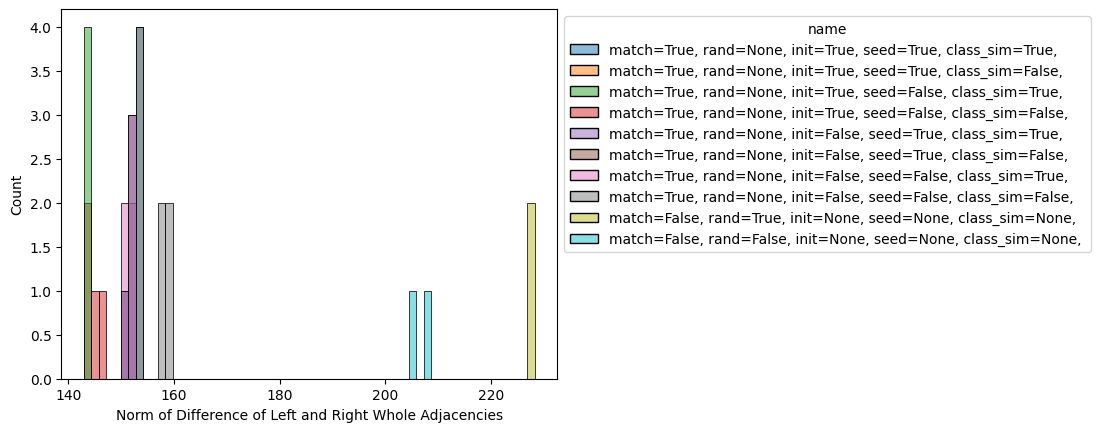

In [500]:
ax_whole = sns.histplot(data=df_whole, x="norm", hue="name")
ax_whole.set_xlabel("Norm of Difference of Left and Right Whole Adjacencies")
sns.move_legend(ax_whole, "upper left", bbox_to_anchor=(1, 1))

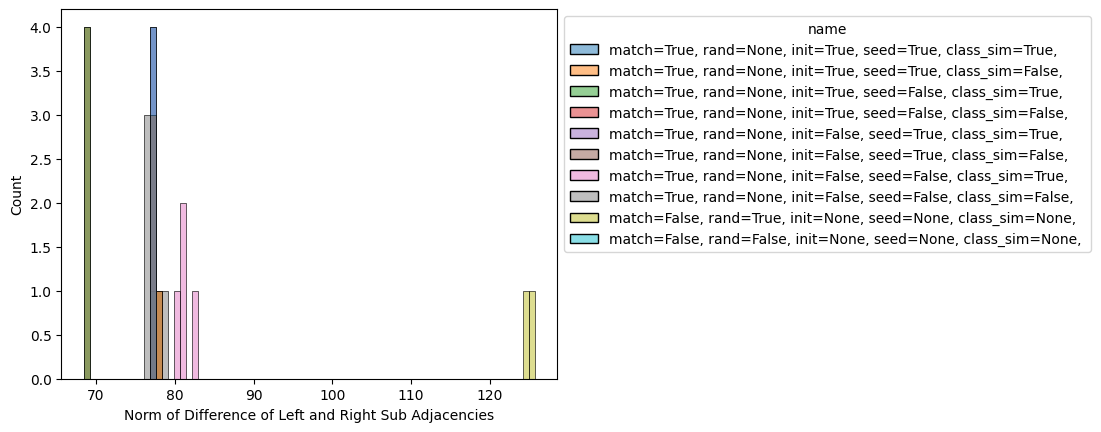

In [501]:
ax_sub = sns.histplot(data=df_sub, x="norm", hue="name")
ax_sub.set_xlabel("Norm of Difference of Left and Right Sub Adjacencies")
sns.move_legend(ax_sub, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
whole_values = init_skids_and_adjs_v2(type="whole")
whole_left_adj = whole_values["left_adj"]
whole_right_adj = whole_values["right_adj"]
whole_left_skids_in_pairs = whole_values["left_skids_in_pairs"]
whole_left_skids_to_match = whole_values["left_skids_to_match"]
whole_right_skids_to_match = whole_values["right_skids_to_match"]
num_pairs = whole_values["num_pairs"]
whole_class_sim = whole_values["class_sim_mat"]

In [ ]:
partial_match_test = np.stack((np.arange(whole_values["num_pairs"]), np.arange(whole_values["num_pairs"]))).T
max_dim = max(len(whole_left_skids_to_match), len(right_skids_to_match))
init_test = np.eye(max_dim-num_pairs)
init_test_2 = np.eye(max_dim)
S_test = whole_class_sim

In [ ]:
init_test.shape

In [ ]:
dfs, inds_left, inds_right = match_skid_dims(whole_left_skids_to_match, whole_right_skids_to_match, num_pairs, n_iters)
#print(whole_left_adj_list[0][np.ix_(inds[0], inds[0])].shape)

In [ ]:
print(whole_left_skids_to_match_list[0])
rand_ind_left = rng.choice(len(whole_left_skids_to_match_list[0][num_pairs:]), size=len(whole_right_skids_to_match_list[0][num_pairs:]), replace=False)
test = whole_left_skids_to_match_list[0][num_pairs:][rand_ind_left]
print(len(test))

In [ ]:
whole_left_adj_list[0].shape
np.all(whole_left_adj_list[0][np.ix_(np.arange(len(whole_left_adj_list[0])), np.arange(len(whole_left_adj_list[0])))] == whole_left_adj_list[0])

Run graph matching without any initialization of the matrices

In [ ]:
#WHOLE, DEFAULT, OPT
ind_left_list = []
ind_right_list = []
n_iter_test = 2

#run graph matching on the pairs of adjs n_iters times
for i in range(n_iter_test):
    ind_left, ind_right, score, misc = graph_match(whole_left_adj, whole_right_adj)
    ind_left_list.append(ind_left)
    ind_right_list.append(ind_right)

In [ ]:
test = np.array(ind_left_list[0])
print(test == np.arange(967))
print(len(test))

In [ ]:
matched_pairs_df_list = gen_df_of_pairs(whole_left_skids_to_match, ind_left_list, whole_right_skids_to_match, ind_right_list)
print(np.all(matched_pairs_df_list[0]["skid-ID LEFT"] == matched_pairs_df_list[1]["skid-ID LEFT"]))

In [ ]:
agreement_list, left_matched_to_consider = calc_agreement(matched_pairs_df_list, whole_left_skids_in_pairs)
agreement_list

In [ ]:
whole_norm_list = calc_norm(whole_left_adj, ind_left_list, whole_right_adj, ind_right_list)
whole_norm_list

Permute the skids based on graph matching, this gives us the pairs from graph matching

In [ ]:
matched_pairs_list = []

for i in range(n_iters):
    left_matched_skids = left_skids[ind_left_list[i]]
    right_matched_skids = right_skids[ind_right_list[i]]

    #make dataframe for the matched pairs
    matched_pairs = pd.DataFrame(list(zip(left_matched_skids, right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    matched_pairs_list.append(matched_pairs)

Calculating the accuracy of how graph matching did (compare our pairs to Nadine's pairs)

In [ ]:
accuracy_list = []
df_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    df = pd.merge(true_pairs, matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')
    df_list.append(df)
    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = df[df.duplicated("skid-ID LEFT")]
    duplicate_R = df[df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    accuracy = num/den
    accuracy_list.append(accuracy)
    #print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [ ]:
#treat df1 as the true/nadine pairs, and the columns of df2 as the extracted left and right indexes from the left and right adjacencies
df1 = pd.DataFrame({'L': [1, 2, 3, 4, 7, 6, 5, 8], 'R': ["a", "b", "c", "d", "g", "f", "e", "h"]})
df2 = pd.DataFrame({'L': [1, 3, 12, 9, 10, 11, 2, 4, 6, 5], 'R': ["a", "d", "h", "r", "f", "u", "b", "w", "q", "c"]})
print("df1")
print(df1, "\n")
print("df2")
print(df2)

In [ ]:
#format df2 by initializing as I have done previously

#grab the neurons that are paired in df1, and both neurons in that pair exist in the L and R column of df2 respectively
L2_list = list(df2.L)
R2_list = list(df2.R)

L2_in_pair = []
R2_in_pair = []

for i in range(len(df1)):
    if(df1.loc[i, "L"] in L2_list and df1.loc[i, "R"] in R2_list):
        L2_in_pair.append(df1.loc[i, "L"])
        R2_in_pair.append(df1.loc[i, "R"])

print(L2_in_pair)
print(R2_in_pair)

In [ ]:
from numpy.random import default_rng
rng = default_rng()

#grab the rest of the neurons in the L and R column of df2, and shuffle them
L2_not_in_pair = np.array([val for val in L2_list if val not in L2_in_pair])
R2_not_in_pair = np.array([val for val in R2_list if val not in R2_in_pair])


#shuffle the lists
rand_ind_left = rng.choice(len(L2_not_in_pair), size=len(L2_not_in_pair), replace=False)
L2_not_in_pair_rand = L2_not_in_pair[rand_ind_left]

rand_ind_right = rng.choice(len(R2_not_in_pair), size=len(R2_not_in_pair), replace=False)
R2_not_in_pair_rand = R2_not_in_pair[rand_ind_right]

print(L2_not_in_pair_rand)
print(R2_not_in_pair_rand)

In [ ]:
#concatenate the pairs and not pairs lists

L2_to_match = np.append(L2_in_pair, L2_not_in_pair_rand, axis=0)
R2_to_match = np.append(R2_in_pair, R2_not_in_pair_rand, axis=0)

pairs = pd.DataFrame(list(zip(L2_to_match, R2_to_match)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
pairs

In [ ]:
#simulate graph matching on these pairs, keep the second and third row intact but the others different
right_list_after_matching = ["r", "b", "c", "a", "d", "f", "w", "u", "h", "q"]

updated_pairs = pairs.copy()
updated_pairs["skid-ID RIGHT"] = right_list_after_matching
print(updated_pairs)

#should expect accuracy of 0.4

In [ ]:
#calcuate accuracy
mask = updated_pairs["skid-ID LEFT"].index < len(L2_in_pair)
L2_to_consider = updated_pairs["skid-ID LEFT"][mask]
R2_to_consider = updated_pairs["skid-ID RIGHT"][mask]

matched_pairs_test = pd.Series(index = L2_to_consider.values, data = R2_to_consider.values)

#find the R1 values that correspond to the L2_to_consider values
R1_to_consider = df1.loc[df1["L"].isin(L2_to_consider.values), "R"]

true_pairs_test = pd.Series(index = L2_to_consider.values, data = R1_to_consider.values)

print(true_pairs_test)
print(matched_pairs_test)
(matched_pairs_test == true_pairs_test).mean()

In [ ]:
new_df = pd.merge(df1, df2, on=["L", 'R'], how="outer", indicator="exist")
test_num = new_df["exist"].value_counts()["both"]
duplicate_L = new_df[new_df.duplicated(['L'])]
duplicate_R = new_df[new_df.duplicated(['R'])]
new_df

In [ ]:
print(duplicate_L)
print(duplicate_R)
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["L", "R"], how="outer", indicator="Exist")
acc = test_num / (test_num + len(duplicate_df))
print(acc)
duplicate_df

Calculate the norm of the difference of the two adjacencies after permuting the skids

In [ ]:
diff_matched_norm_list = []
for i in range(n_iters):
    #norms of matched adjs
    #subset and permute the adjacencies by their indices from matching
    np_left_adj_matched = np_left_adj[np.ix_(ind_left_list[i], ind_left_list[i])]
    np_right_adj_matched = np_right_adj[np.ix_(ind_right_list[i], ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_diff_adj_matched = np_left_adj_matched - np_right_adj_matched
    diff_matched_norm = np.linalg.norm(np_diff_adj_matched)
    diff_matched_norm_list.append(diff_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {diff_matched_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_left_adj), size=len(np_right_adj), replace=False)
    np_left_adj_rand = np_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_right_adj), size=len(np_right_adj), replace=False)
    np_right_adj_rand = np_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_diff_adj_rand = np_left_adj_rand - np_right_adj_rand
    diff_rand_norm = np.linalg.norm(np_diff_adj_rand)
    rand_norms_whole.append(diff_rand_norm)


In [ ]:
accuracy_mean = np.average(accuracy_list)
norm_mean = np.average(diff_matched_norm_list)

Plot histogram showing how our norm compares to the norms after random permutations of the matrices

In [ ]:
#histogram
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole)
ax.axvline(norm_mean, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(norm_mean, accuracy_mean))

Look at morphologies of neurons that were paired correctly, 5 morphologies of neurons that were paired correctly in only Nadine's, and 5 morphologies of neurons that were paired in ours

In [ ]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

In [ ]:
#look at correct morphologies
import navis

#make list of CatmaidNeuronList for each pair of neurons
neuron_list_both = []
neuron_list_nadine = []
neuron_list_ours = []

for ind, row in df.iterrows():
    neurons = [row["skid-ID LEFT"], row["skid-ID RIGHT"]]

    #when the pair exists in both our list and Nadine's list
    if(row["Exist"] == "both"):
        neuron_list_both.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])
    
    #when the pair exists in Nadine's list only
    elif(row["Exist"] == "left_only" and len(neuron_list_nadine)<=5):
        neuron_list_nadine.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])
    
    #when the pair exists in our list only
    elif(row["Exist"] == "right_only" and len(neuron_list_ours)<=5):
        neuron_list_ours.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])

In [ ]:
#visualize correctly matched neurons
for i in range(len(neuron_list_both)):
    fig, ax = navis.plot2d(neuron_list_both[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_both[i][1]
    right = neuron_list_both[i][2]
    ax.set_title(f"Correctly matched {left} and {right}")

In [ ]:
#visualize neurons that nadines matched that was not in ours
for i in range(len(neuron_list_nadine)):
    fig, ax = navis.plot2d(neuron_list_nadine[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_nadine[i][1]
    right = neuron_list_nadine[i][2]
    ax.set_title(f"Nadine matched {left} and {right}")

In [ ]:
#visualize neurons that we matched that nadine did not
for i in range(len(neuron_list_ours)):
    fig, ax = navis.plot2d(neuron_list_ours[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_ours[i][1]
    right = neuron_list_ours[i][2]
    ax.set_title(f"We matched {left} and {right}")

Look at what happens if we initialize a permutation matrix such that the left and right adjs match Nadine's pairs

In [ ]:
#first move all the left skids that are in Nadine's list to the front of the left skids list
left_skids_copy = np.array(left_skids)

#find left indices that correspond to Nadine's list
inds_nadine = [list(np.where(left_skids_copy == j)[0]) for j in left_true]

#modify inds_nadine to get rid of all empty lists (skids that exist in Nadine's skid list but not ours) and make list elements as ints
inds_nadine_filt = [ele[0] for ele in inds_nadine if ele != []]
inds_nadine_filt = np.array(inds_nadine_filt)

#save the elements that correspond (and not) to inds_nadine_filt in left_skids_copy
skids_left_nadine = left_skids_copy[inds_nadine_filt]
skids_left_not_nadine = [skid for skid in left_skids_copy if skid not in skids_left_nadine]
skids_left_not_nadine = np.array(skids_left_not_nadine)

#now concatenate the nadine skids and not_nadine left skids
skids_left_form = np.append(skids_left_nadine, skids_left_not_nadine, axis=0)

#now permute the right index list such that the pairs align with Nadine's
right_skids_copy = np.array(right_skids)

#go through the first entires of left_skids_copy and find the right_skid that corresponds to it in true_pairs
for i in range(len(inds_nadine_filt)):

    #find the index where the current left skid appears in true pairs
    ind_pair = true_pairs.loc[true_pairs["skid-ID LEFT"] == skids_left_form[i]].index[0]

    #find the right skid that corresponds to the left_skid in true pairs
    right_skid = true_pairs.loc[ind_pair, "skid-ID RIGHT"]

    #find where this right_skid is in our right_skids list, if it is not there then continue
    if right_skid not in right_skids_copy:
        continue
    
    else:
        
        #swap right_skid with the skid where it needs to go
        ind_right_curr = np.where(right_skids_copy == right_skid)[0][0]
        temp = right_skids_copy[i]
        right_skids_copy[i] = right_skid
        right_skids_copy[ind_right_curr] = temp
        
skids_right_form = right_skids_copy.copy()
whole_nadine_nadine_pairs = pd.DataFrame(list(zip(skids_left_form, skids_right_form)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])

In [ ]:
whole_nadine_nadine_pairs

Calculate the accuracy of our permuted left and right skids do (without running graph matchingf)

In [ ]:
#Accuracy of WHOLE, NADINE, NADINE

#merge the true pairs and our matched pairs by their union
whole_nadine_df = pd.merge(true_pairs, whole_nadine_nadine_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = whole_nadine_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = whole_nadine_df[whole_nadine_df.duplicated("skid-ID LEFT")]
duplicate_R = whole_nadine_df[whole_nadine_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num
accuracy_whole_nadine_nadine = num/den
print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

Calculate the norms of the left and right adjs after permuting the skids (no graph matching)

In [ ]:
#norms of whole nadine init adjs

#chop the last skids of the left skid list so the dimensions match
skids_left_form_trunc = skids_left_form[0:len(skids_right_form)]

#make adjs
whole_nadine_left_adj = pymaid.adjacency_matrix(skids_left_form)
whole_nadine_left_adj_trunc = pymaid.adjacency_matrix(skids_left_form_trunc)
whole_nadine_right_adj = pymaid.adjacency_matrix(skids_right_form)

np_whole_nadine_left_adj = np.array(whole_nadine_left_adj)
np_whole_nadine_left_adj_trunc = np.array(whole_nadine_left_adj_trunc)
np_whole_nadine_right_adj = np.array(whole_nadine_right_adj)

#calculate norm of difference of matched adjacencies
np_diff_whole_nadine = np_whole_nadine_left_adj_trunc - np_whole_nadine_right_adj
diff_whole_nadine_norm = np.linalg.norm(np_diff_whole_nadine)

print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_nadine_left_adj_trunc), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_nadine_left_adj_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_nadine_right_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [ ]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(diff_whole_nadine_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_whole_nadine_norm, accuracy_whole_nadine_nadine))

Run graph matching on our permuted adjs

In [ ]:
whole_nadine_ind_left_list = []
whole_nadine_ind_right_list = []

In [ ]:
#WHOLE, NADINE, OPT
for i in range(n_iters):
    whole_nadine_ind_left, whole_nadine_ind_right, score, _ = graph_match(np_whole_nadine_left_adj, np_whole_nadine_right_adj)
    whole_nadine_ind_left_list.append(whole_nadine_ind_left)
    whole_nadine_ind_right_list.append(whole_nadine_ind_right)

In [ ]:
#score from WHOLE NADINE OPT
score

In [ ]:
whole_nadine_matched_pairs_list = []
for i in range(n_iters):
    skids_left_form_matched = skids_left_form[whole_nadine_ind_left_list[i]]
    skids_right_form_matched = skids_right_form[whole_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs = pd.DataFrame(list(zip(skids_left_form_matched, skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_list.append(whole_nadine_matched_pairs)

Calculate the accuracy after running graph matching on our permuted adjs

In [ ]:
#WHOLE, NADINE, OPT
whole_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_df = pd.merge(true_pairs, whole_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    accuracy = num/den
    whole_nadine_matched_accuracy_list.append(accuracy)
    #print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

Calculate norm from running graph matching on our permuted adjs

In [ ]:
#norms of whole nadine init opt adjs
whole_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_left_adj = np_whole_nadine_left_adj[np.ix_(whole_nadine_ind_left_list[i], whole_nadine_ind_left_list[i])]
    np_whole_nadine_matched_right_adj = np_whole_nadine_right_adj[np.ix_(whole_nadine_ind_right_list[i], whole_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_diff = np_whole_nadine_matched_left_adj - np_whole_nadine_matched_right_adj
    diff_whole_nadine_matched_norm = np.linalg.norm(np_whole_nadine_matched_diff)
    whole_nadine_matched_norm_list.append(diff_whole_nadine_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_nadine_left_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_nadine_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_nadine_right_adj), size=len(np_whole_nadine_right_adj), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [ ]:
whole_nadine_matched_norm_average = np.average(whole_nadine_matched_norm_list)
whole_nadine_matched_accuracy_average = np.average(whole_nadine_matched_accuracy_list)

In [ ]:
#histogram of WHOLE NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average))

Do all the same analyses, but run on the subgraph (from our total list of left and right neurons, use the subsets of the neurons that exist in true pairs)

In [ ]:
sub_left_skids = [skid for skid in left_skids if skid in left_true]
sub_right_skids = [skid for skid in right_skids if skid in right_true]

pd_sub_left_skids = pd.Series(sub_left_skids)
pd_sub_right_skids = pd.Series(sub_right_skids)

print(len(sub_left_skids))
print(len(sub_right_skids))

In [ ]:
#get the sub labels for class similarity purposes

#find the inds from left and right skid lists that are in the respective subgraphs
left_inds = [i for i, e in enumerate(left_skids) if e in sub_left_skids]
right_inds = [i for i, e in enumerate(right_skids) if e in sub_right_skids]

#np_left_labels = np.array(left_labels)
#np_right_labels = np.array(right_labels)

#grab the subset of labels from the ind lists
sub_left_labels = np_left_labels[left_inds]
sub_right_labels = np_left_labels[right_inds]

In [ ]:
sub_left_adj = pymaid.adjacency_matrix(sub_left_skids)
sub_right_adj = pymaid.adjacency_matrix(sub_right_skids)

np_sub_left_adj = np.array(sub_left_adj)
np_sub_right_adj = np.array(sub_right_adj)

In [ ]:
sub_ind_left_list = []
sub_ind_right_list = []

Run graph matching without any initialization

In [ ]:
#SUB, DEFAULT, OPT
for i in range(n_iters):
    sub_ind_left, sub_ind_right, sub_score, sub_misc = graph_match(np_sub_left_adj, np_sub_right_adj)
    sub_ind_left_list.append(sub_ind_left)
    sub_ind_right_list.append(sub_ind_right)

In [ ]:
#Score from SUB, DEFAULT, OPT
sub_score

Permute our lists of skids based on the results of graph matching

In [ ]:
sub_matched_pairs_list = []
for i in range(n_iters):
    sub_left_matched_skids = pd_sub_left_skids[sub_ind_left_list[i]]
    sub_right_matched_skids = pd_sub_right_skids[sub_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_matched_pairs = pd.DataFrame(list(zip(sub_left_matched_skids, sub_right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_matched_pairs_list.append(sub_matched_pairs)

Calculate the accuracy on our subgraphs after graph matching without initialization

In [ ]:
sub_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_df = pd.merge(true_pairs, sub_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    sub_num = sub_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_df[sub_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_df[sub_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    sub_den = len(duplicate_df) + sub_num
    accuracy = sub_num/sub_den
    sub_matched_accuracy_list.append(accuracy)

    #print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(sub_num/sub_den))

Collect the neurons that were correctly matched from graph matching

In [ ]:
correct_sub_df = sub_df.loc[sub_df["Exist"] == "both"]
correct_sub_df = correct_sub_df.reset_index()
correct_sub_df

Visualize the correctly matched neurons

In [ ]:
import navis

#make list of CatmaidNeuronList for each pair of neurons
neuron_list = []
for ind, row in correct_sub_df.iterrows():
    neurons = [row["skid-ID LEFT"], row["skid-ID RIGHT"]]
    neuron_list.append(pymaid.get_neuron(neurons))

neuron_list

In [ ]:
for i in range(len(neuron_list)):
    fig, ax = navis.plot2d(neuron_list[i], method='2d', view=('x', '-y'))
    left = correct_sub_df.loc[i, "skid-ID LEFT"]
    right = correct_sub_df.loc[i, "skid-ID RIGHT"]
    ax.set_title(f"{left} and {right}")

Take the norm of our subgraphs from graph matching

In [ ]:
#norms of matched adjs
#subset and permute the adjacencies by their indices from matching
sub_matched_norm_list = []
for i in range(n_iters):
    np_sub_left_adj_matched = np_sub_left_adj[np.ix_(sub_ind_left_list[i], sub_ind_left_list[i])]
    np_sub_right_adj_matched = np_sub_right_adj[np.ix_(sub_ind_right_list[i], sub_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_diff_adj_matched = np_sub_left_adj_matched - np_sub_right_adj_matched
    sub_diff_matched_norm = np.linalg.norm(np_sub_diff_adj_matched)
    sub_matched_norm_list.append(sub_diff_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {sub_diff_matched_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj), size=len(np_sub_right_adj), replace=False)
    np_sub_left_adj_rand = np_sub_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj), size=len(np_sub_right_adj), replace=False)
    np_sub_right_adj_rand = np_sub_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_diff_adj_rand = np_sub_left_adj_rand - np_sub_right_adj_rand
    sub_diff_rand_norm = np.linalg.norm(np_sub_diff_adj_rand)
    rand_norms.append(sub_diff_rand_norm)

#print(f"Norm of difference of left and right randomly permuted adjs: {sub_diff_rand_norm}")

In [ ]:
sub_matched_norm_average = np.average(sub_matched_norm_list)
sub_matched_accuracy_average = np.average(sub_matched_accuracy_list)

In [ ]:
#histogram
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms)
ax.axvline(sub_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average))

Look at what happens if we initialize a permutation matrix such that the left and right adjs match Nadine's pairs

In [ ]:
#first move all the right skids that are in Nadine's list to the front of the right skids list
#note: doing right skids instead of left skids first because will go out of bounds when starting with left skids
sub_right_skids_copy = np.array(sub_right_skids)

#find right indices that correspond to Nadine's list
sub_inds_nadine = [list(np.where(sub_right_skids_copy == j)[0]) for j in right_true]

#modify inds_nadine to get rid of all empty lists and make list elements as ints
sub_inds_nadine_filt = [ele[0] for ele in sub_inds_nadine if ele != []]
sub_inds_nadine_filt = np.array(sub_inds_nadine_filt)

#save the elements that correspond (and not) to inds_nadine_filt in sub_right_skids_copy
sub_skids_right_nadine = sub_right_skids_copy[sub_inds_nadine_filt]
sub_skids_right_not_nadine = [skid for skid in sub_right_skids_copy if skid not in sub_skids_right_nadine]
sub_skids_right_not_nadine = np.array(sub_skids_right_not_nadine)

#now concatenate the nadine skids and not_nadine right skids
sub_skids_right_form = np.append(sub_skids_right_nadine, sub_skids_right_not_nadine, axis=0)

#now permute the left index list such that the pairs align with Nadine's
sub_left_skids_copy = np.array(sub_left_skids)

#go through the first entries of right_skids_copy and find the left_skid that corresponds to it in true_pairs
for i in range(len(sub_inds_nadine_filt)):
    
    #get the left skid which exists in nadine's pairs
    right_skid = sub_skids_right_form[i]

    #find the left skid that corresponds to the left_skid in true_pair
    sub_ind_pair = true_pairs.loc[true_pairs["skid-ID RIGHT"] == sub_skids_right_form[i]].index[0]
    left_skid = true_pairs.loc[sub_ind_pair, "skid-ID LEFT"]

    #find where this left_skid is in the left_skids list, if it is not there then continue
    if left_skid not in sub_left_skids_copy:
        continue
    
    else:
        #swap left_skid with the skid where it needs to go
        ind_left_curr = np.where(sub_left_skids_copy == left_skid)[0][0]
        temp = sub_left_skids_copy[i]
        sub_left_skids_copy[i] = left_skid
        sub_left_skids_copy[ind_left_curr] = temp
        
sub_skids_left_form = sub_left_skids_copy.copy()
sub_nadine_nadine_pairs = pd.DataFrame(list(zip(sub_skids_left_form, sub_skids_right_form)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])

Calculate the accuracy on our subgraphs after initialization without graph matching

In [ ]:
#Accuracy for SUB, NADINE, NADINE

#merge the true pairs and our matched pairs by their union
sub_nadine_df = pd.merge(true_pairs, sub_nadine_nadine_pairs, on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

#the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
num = sub_nadine_df["Exist"].value_counts()["both"]

#to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
duplicate_L = sub_nadine_df[sub_nadine_df.duplicated("skid-ID LEFT")]
duplicate_R = sub_nadine_df[sub_nadine_df.duplicated("skid-ID RIGHT")]

#take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
#repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

#the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
den = len(duplicate_df) + num
diff_sub_nadine_accuracy = num/den
print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))


Calculate the norm of our subgraphs after initialization without graph matching

In [ ]:
#norms of whole nadine init adjs

#chop the last skids of the left skid list so the dimensions match
sub_skids_left_form_trunc = sub_skids_left_form[0:len(sub_skids_right_form)]

#make adjs
sub_nadine_left_adj = pymaid.adjacency_matrix(sub_skids_left_form)
sub_nadine_left_adj_trunc = pymaid.adjacency_matrix(sub_skids_left_form_trunc)
sub_nadine_right_adj = pymaid.adjacency_matrix(sub_skids_right_form)

np_sub_nadine_left_adj = np.array(sub_nadine_left_adj)
np_sub_nadine_left_adj_trunc = np.array(sub_nadine_left_adj_trunc)
np_sub_nadine_right_adj = np.array(sub_nadine_right_adj)

#calculate norm of difference of matched adjacencies
np_diff_sub_nadine = np_sub_nadine_left_adj_trunc - np_sub_nadine_right_adj
diff_sub_nadine_norm = np.linalg.norm(np_diff_sub_nadine)

print(f"Norm of difference of left and right subgraph Nadine initialized adjs: {diff_sub_nadine_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_nadine_left_adj_trunc), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_nadine_left_adj_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_nadine_right_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [ ]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(diff_sub_nadine_norm, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_sub_nadine_norm, diff_sub_nadine_accuracy))

Run graph matching on our subgraphs after initialization

In [ ]:
sub_nadine_ind_left_list = []
sub_nadine_ind_right_list = []

In [ ]:
#SUB, NADINE, OPT
for i in range(n_iters):
    sub_nadine_ind_left, sub_nadine_ind_right, sub_score_align, _ = graph_match(np_sub_nadine_left_adj, np_sub_nadine_right_adj)
    sub_nadine_ind_left_list.append(sub_nadine_ind_left)
    sub_nadine_ind_right_list.append(sub_nadine_ind_right)

In [ ]:
#SUB, NADINE, OPT
sub_score_align

In [ ]:
sub_nadine_matched_pairs_list = []
for i in range(n_iters):
    sub_skids_left_form_matched = sub_skids_left_form[sub_nadine_ind_left_list[i]]
    sub_skids_right_form_matched = sub_skids_right_form[sub_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs = pd.DataFrame(list(zip(sub_skids_left_form_matched, sub_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_list.append(sub_nadine_matched_pairs)

Accuracy on our subgraphs after initialization and graph matching

In [ ]:
#SUB, NADINE, OPT
sub_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_df = pd.merge(true_pairs, sub_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_accuracy = num/den
    sub_nadine_matched_accuracy_list.append(sub_nadine_accuracy)

    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

Calculate norm of our subgraphs after initialization and graph matching

In [ ]:
#norms of sub nadine init opt adjs
sub_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_left_adj = np_sub_nadine_left_adj[np.ix_(sub_nadine_ind_left_list[i], sub_nadine_ind_left_list[i])]
    np_sub_nadine_matched_right_adj = np_sub_nadine_right_adj[np.ix_(sub_nadine_ind_right_list[i], sub_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_diff = np_sub_nadine_matched_left_adj - np_sub_nadine_matched_right_adj
    diff_sub_nadine_matched_norm = np.linalg.norm(np_sub_nadine_matched_diff)
    sub_nadine_matched_norm_list.append(diff_sub_nadine_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_nadine_left_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_whole_nadine_left_adj_rand = np_sub_nadine_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_nadine_right_adj), size=len(np_sub_nadine_right_adj), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_nadine_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [ ]:
sub_nadine_matched_norm_average = np.average(sub_nadine_matched_norm_list)
sub_nadine_matched_accuracy_average = np.average(sub_nadine_matched_accuracy_list)

In [ ]:
#histogram of SUB NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average))

In [ ]:
from numpy.random import default_rng

rng = default_rng()
numbers = rng.choice(20, size=10, replace=False)
numbers

In [ ]:
x = np.linspace(0, 1, 3)
y = np.linspace(0, 1, 2)
xv, yv = np.meshgrid(x, y)
xv

In [ ]:
n1 = np.arange(5)
n2 = np.arange(4)
a = np.arange(100)
a.shape = (10,10)
a[np.ix_(n1, n2)]

We will construct a permutation matrix P such that PBP^T causes correspondance to Nadine's pairs for both the subgraphs and the whole graphs

- Let's say we are at row i in our left subgraph, and obviously since this is a subgraph of the Nadine paired neurons, the skid of this row is going to be in the left true list since it has been matched by Nadine
    - If we go through the whole adjs, then if the left neuron is not in the true_pairs, then continue to next row in left graph
- Need to go through true_pairs to find the right neuron that our current left neuron corresponds to, and need to find the row where this neuron is in the right subgraph
    - In this row put a 1 in position i and a 0 everywhere else in the row
    - Keep track of the i's in which we fill the corresponding rows out
    - If we go through the right graph and the right neuron that we found earlier is not a skid in the right graph, then continue to next row in left graph
- In the rows of the right graph we did not examine put a 1 in a random spot that does not correspond to an i and 0's elsewhere
    - Keep track of each spot where the 1 was added in these random rows, cannot add a 1 in a differnt row in that same spot
- After constructing permutation matrix P, then do PBP^T, then do next steps



Optimization methods

- Nadine's pairs: make permutation matrix to correspond to Nadine's pairs in previous step and calculate accuracy and norm (can't do for default because need permutation matrix) (both subgraph and whole) (?)
- Opt: run graph matching and calculate accuracy and norm (for both default and Nadine permutation) (both subgraph and whole) see if score from graph matching with default initialization is worse than if initializing with permutation matrix
- Random: do random permutations of the rows of the right graph and calculate accuracy and norm (for both default and Nadine permutation) (both subgraph and whole)
- Focus on whole adjs

- Look at graph matching for the whole left and right graphs and compute accuracy and norm histogram (make sure to subset Nadine's true pairs correctly) (ensure accuracy is calculated correctly: look at picture of board to see how that is done)
- Show morphologies for 10 of the pairs that we matched that are not in Nadine's and 10 of the pairs that Nadine matched that are not in ours 
- Calculate norms for several situations (Nadine's subgraphs vs whole graphs, default init vs Nadine init (make permutation matrix such that PBP^T causes correspondance to Nadine's pairs (can verify with Pedigo after making)) optimization method (use nadine's pairs straightup on the subgraph, graph matching, random))
- (Note: when constructing permutation matrix to correspond to Nadine's pairs when using the entire whole graphs, can use random entries for the rows that do not correspond to Nadine's pairs (refer to "up" on graph: rows for permutation matrix there will be random))

- Make Gantt Chart timeline for what I need to get done
- Make permutation matrix by extracting the left and right skids and then rearranging the right skids such that it matches Nadine's pairs and then make adjacency matrix for right by reindexing, then the permutation matrix would be identity
- Get accuracies and norms for default and Nadine init with diff optimization methods (focus on Nadine's pairs and whole adjs), look at score from graph matching with default and see if worse than if initializing with permutation matrix 

- Go through Nadine's pairs, and find the pairs where the left neuron exists in our left skids and the right neurons exists in our right skids
    - L1: list of left neurons here, R1: list of right neurons here
- Go through our left and right skids, collect the skids that are not in L1 and R1, call these lists L2 and R2
- Shuffle L2 and R2
- L3 = L1 + L2, R3 = R1 + R2
- Extract adjacencies using these lists of skids using pymaid
- Run graph matching on adjacencies using an init parameter which will be an identity matrix the size of the larger of the two matrices
- Calculate norm and accuracy from graph matching

Do the initialization on the whole graph

In [ ]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
whole_left_skids_in_pairs = []
whole_right_skids_in_pairs = []

#iterate through Nadine's list
for i in range(len(true_pairs)):
    if (true_pairs.loc[i, "skid-ID LEFT"] in left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in right_skids):
        whole_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        whole_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

In [ ]:
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them
whole_left_skids_not_pairs = np.array([skid for skid in left_skids if skid not in whole_left_skids_in_pairs])
whole_right_skids_not_pairs = np.array([skid for skid in right_skids if skid not in whole_right_skids_in_pairs])

whole_left_skids_not_pairs_rand_list = []
whole_right_skids_not_pairs_rand_list = []

#shuffle the lists n_iters times
for i in range(n_iters):
    rand_ind_left = rng.choice(len(whole_left_skids_not_pairs), size=len(whole_left_skids_not_pairs), replace=False)
    whole_left_skids_not_pairs_rand = whole_left_skids_not_pairs[rand_ind_left]
    whole_left_skids_not_pairs_rand_list.append(whole_left_skids_not_pairs_rand)

    rand_ind_right = rng.choice(len(whole_right_skids_not_pairs), size=len(whole_right_skids_not_pairs), replace=False)
    whole_right_skids_not_pairs_rand = whole_right_skids_not_pairs[rand_ind_right]
    whole_right_skids_not_pairs_rand_list.append(whole_right_skids_not_pairs_rand)

In [ ]:
#concatenate the pairs and not pairs lists
whole_left_skids_to_match_list = []
whole_right_skids_to_match_list = []
whole_nadine_pairs_list = []

for i in range(n_iters):
    whole_left_skids_to_match = np.append(whole_left_skids_in_pairs, whole_left_skids_not_pairs_rand_list[i], axis=0)
    whole_left_skids_to_match_list.append(whole_left_skids_to_match)

    whole_right_skids_to_match = np.append(whole_right_skids_in_pairs, whole_right_skids_not_pairs_rand_list[i], axis=0)
    whole_right_skids_to_match_list.append(whole_right_skids_to_match)

    #Some of the last skids of the left list are removed so that the dimensions match in the dataframe
    whole_nadine_pairs = pd.DataFrame(list(zip(whole_left_skids_to_match, whole_right_skids_to_match)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_pairs_list.append(whole_nadine_pairs)

Calculate the norm and accuracy of the initialized skids before graph matching

In [ ]:
#WHOLE, NADINE, NADINE
whole_to_match_accuracy_list = []

for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_df = pd.merge(true_pairs, whole_nadine_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_df[whole_nadine_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_df[whole_nadine_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_to_match_accuracy = num/den
    whole_to_match_accuracy_list.append(whole_to_match_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [ ]:
#norms of whole nadine init adjs
diff_whole_to_match_norm_list = []

for i in range(n_iters):
    #chop the last skids of the left skid list so the dimensions match
    whole_left_skids_to_match_trunc = whole_left_skids_to_match_list[i][0:len(whole_right_skids_to_match_list[i])]

    #make adjs from skids
    whole_left_adj_to_match = pymaid.adjacency_matrix(whole_left_skids_to_match_list[i])
    whole_left_adj_to_match_trunc = pymaid.adjacency_matrix(whole_left_skids_to_match_trunc)
    whole_right_adj_to_match = pymaid.adjacency_matrix(whole_right_skids_to_match_list[i])

    #convert adjs to numpy
    np_whole_left_adj_to_match = np.array(whole_left_adj_to_match)
    np_whole_left_adj_to_match_trunc = np.array(whole_left_adj_to_match_trunc)
    np_whole_right_adj_to_match = np.array(whole_right_adj_to_match)

    #calculate norm of difference of matched adjacencies
    np_diff_whole_nadine = np_whole_left_adj_to_match_trunc - np_whole_right_adj_to_match
    diff_whole_to_match_norm = np.linalg.norm(np_diff_whole_nadine)
    diff_whole_to_match_norm_list.append(diff_whole_to_match_norm)

    print(f"Norm of difference of left and right matched adjs: {diff_whole_to_match_norm}")

In [ ]:
whole_left_skids_to_match_trunc[1200:1205]

In [ ]:
whole_nadine_pairs

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):

    #randomly subset the truncated left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match_trunc), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [ ]:
diff_whole_to_match_norm_average = np.average(diff_whole_to_match_norm_list)
whole_to_match_accuracy_average = np.average(whole_to_match_accuracy)

In [ ]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(diff_whole_to_match_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average))

In [ ]:
whole_nadine_ind_left_list = []
whole_nadine_ind_right_list = []
n_iters = 10
#make identity matrix that is the size of the bigger matrix as the permutation matrix to initialize graph matching
perm_mat = np.eye(max(len(whole_left_skids_to_match), len(whole_right_skids_to_match)))

In [ ]:
#graph match with initialization on whole graph
for i in range(n_iters):
    whole_nadine_ind_left, whole_nadine_ind_right, whole_score_align, _ = graph_match(np_whole_left_adj_to_match, np_whole_right_adj_to_match, init=perm_mat)
    whole_nadine_ind_left_list.append(whole_nadine_ind_left)
    whole_nadine_ind_right_list.append(whole_nadine_ind_right)

In [ ]:
whole_score_align

In [ ]:
whole_nadine_matched_pairs_list = []
for i in range(n_iters):
    whole_skids_left_form_matched = whole_left_skids_to_match[whole_nadine_ind_left_list[i]]
    whole_skids_right_form_matched = whole_right_skids_to_match[whole_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs = pd.DataFrame(list(zip(whole_skids_left_form_matched, whole_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_list.append(whole_nadine_matched_pairs)

In [ ]:
#WHOLE, NADINE, OPT
whole_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_df = pd.merge(true_pairs, whole_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_nadine_matched_accuracy = num/den
    whole_nadine_matched_accuracy_list.append(whole_nadine_matched_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [ ]:
#norms of whole init opt adjs
whole_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_left_adj = np_whole_left_adj_to_match[np.ix_(whole_nadine_ind_left_list[i], whole_nadine_ind_left_list[i])]
    np_whole_nadine_matched_right_adj = np_whole_right_adj_to_match[np.ix_(whole_nadine_ind_right_list[i], whole_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_diff = np_whole_nadine_matched_left_adj - np_whole_nadine_matched_right_adj
    diff_whole_nadine_matched_norm = np.linalg.norm(np_whole_nadine_matched_diff)
    whole_nadine_matched_norm_list.append(diff_whole_nadine_matched_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [ ]:
whole_nadine_matched_norm_average = np.average(whole_nadine_matched_norm_list)
whole_nadine_matched_accuracy_average = np.average(whole_nadine_matched_accuracy_list)

In [ ]:
#histogram of WHOLE NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average))

In [ ]:
n_iters
perm_mat_seed = np.eye(len(np_whole_left_adj_to_match)-len(whole_left_skids_in_pairs))
len(perm_mat_seed)

In [ ]:
#seeded graph matching
partial_match_whole = np.stack(
    (np.arange(len(whole_left_skids_in_pairs)), np.arange(len(whole_right_skids_in_pairs)))
).T

whole_nadine_ind_left_seed_list = []
whole_nadine_ind_right_seed_list = []
for i in range(len(whole_left_adj_list)):
    for j in range(n_iters):
        whole_nadine_ind_left_seed, whole_nadine_ind_right_seed, whole_score_seed, _ = graph_match(whole_left_adj_list[i], whole_right_adj_list[i], partial_match=partial_match_whole)
        whole_nadine_ind_left_seed_list.append(whole_nadine_ind_left_seed)
        whole_nadine_ind_right_seed_list.append(whole_nadine_ind_right_seed)

In [ ]:
matched_pairs_df_list_seed = gen_df_of_pairs(whole_left_skids_to_match_list, whole_nadine_ind_left_seed_list, whole_right_skids_to_match_list, whole_nadine_ind_right_seed_list, n_iters)
len(matched_pairs_df_list_seed)

In [ ]:
agreement_list_seed = calc_agreement(matched_pairs_df_list_seed, 255, n_iters)
agreement_list_seed

In [ ]:
#seeded graph matching
partial_match_whole = np.stack(
    (np.arange(len(whole_left_skids_in_pairs)), np.arange(len(whole_right_skids_in_pairs)))
).T

whole_nadine_ind_left_seed_list = []
whole_nadine_ind_right_seed_list = []
for i in range(n_iters):
    whole_nadine_ind_left_seed, whole_nadine_ind_right_seed, whole_score_seed, _ = graph_match(np_whole_left_adj_to_match, np_whole_right_adj_to_match, partial_match=partial_match_whole)
    whole_nadine_ind_left_seed_list.append(whole_nadine_ind_left_seed)
    whole_nadine_ind_right_seed_list.append(whole_nadine_ind_right_seed)

In [ ]:
print(whole_score_seed)

In [ ]:
whole_nadine_matched_pairs_seed_list = []
for i in range(n_iters):
    whole_skids_left_form_matched_seed = whole_left_skids_to_match[whole_nadine_ind_left_seed_list[i]]
    whole_skids_right_form_matched_seed = whole_right_skids_to_match[whole_nadine_ind_right_seed_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs_seed = pd.DataFrame(list(zip(whole_skids_left_form_matched_seed, whole_skids_right_form_matched_seed)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_seed_list.append(whole_nadine_matched_pairs_seed)

In [ ]:
#WHOLE, NADINE, SEED
whole_nadine_matched_seed_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_seed_df = pd.merge(true_pairs, whole_nadine_matched_pairs_seed_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_seed_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_seed_df[whole_nadine_matched_seed_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_seed_df[whole_nadine_matched_seed_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_nadine_matched_seed_accuracy = num/den
    whole_nadine_matched_seed_accuracy_list.append(whole_nadine_matched_seed_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [ ]:
#norms of whole init seed adjs
whole_nadine_matched_seed_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_seed_left_adj = np_whole_left_adj_to_match[np.ix_(whole_nadine_ind_left_seed_list[i], whole_nadine_ind_left_seed_list[i])]
    np_whole_nadine_matched_seed_right_adj = np_whole_right_adj_to_match[np.ix_(whole_nadine_ind_right_seed_list[i], whole_nadine_ind_right_seed_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_seed_diff = np_whole_nadine_matched_seed_left_adj - np_whole_nadine_matched_seed_right_adj
    diff_whole_nadine_matched_seed_norm = np.linalg.norm(np_whole_nadine_matched_seed_diff)
    whole_nadine_matched_seed_norm_list.append(diff_whole_nadine_matched_seed_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_seed_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [ ]:
whole_nadine_matched_seed_norm_average = np.average(whole_nadine_matched_seed_norm_list)
whole_nadine_matched_seed_accuracy_average = np.average(whole_nadine_matched_seed_accuracy_list)

In [ ]:
#histogram of WHOLE NADINE SEED
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_seed_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of seeded matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_seed_norm_average, whole_nadine_matched_seed_accuracy_average))

In [ ]:
#whole class similarity
whole_class_similarity = (np_left_labels[:, None] == np_right_labels[None, :])

sns.heatmap(
    whole_class_similarity,
    cmap="Blues",
    cbar=False,
    square=True,
    xticklabels=False,
    yticklabels=False,
)

In [ ]:
whole_nadine_ind_left_class_list = []
whole_nadine_ind_right_class_list = []
for i in range(n_iters):
    whole_nadine_ind_left_class, whole_nadine_ind_right_class, whole_score_class, _ = graph_match(np_left_adj, np_right_adj, S=whole_class_similarity, verbose=3)
    whole_nadine_ind_left_class_list.append(whole_nadine_ind_left_class)
    whole_nadine_ind_right_class_list.append(whole_nadine_ind_right_class)

In [ ]:
print(whole_score_class)

In [ ]:
whole_nadine_matched_pairs_class_list = []
for i in range(n_iters):
    whole_skids_left_form_matched_class = whole_left_skids_to_match[whole_nadine_ind_left_class_list[i]]
    whole_skids_right_form_matched_class = whole_right_skids_to_match[whole_nadine_ind_right_class_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs_class = pd.DataFrame(list(zip(whole_skids_left_form_matched_class, whole_skids_right_form_matched_class)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_class_list.append(whole_nadine_matched_pairs_class)

In [ ]:
#WHOLE, NADINE, CLASS
whole_nadine_matched_class_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_class_df = pd.merge(true_pairs, whole_nadine_matched_pairs_class_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_class_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_class_df[whole_nadine_matched_class_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_class_df[whole_nadine_matched_class_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_nadine_matched_class_accuracy = num/den
    whole_nadine_matched_class_accuracy_list.append(whole_nadine_matched_class_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [ ]:
#norms of whole init class adjs
whole_nadine_matched_class_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_class_left_adj = np_left_adj[np.ix_(whole_nadine_ind_left_class_list[i], whole_nadine_ind_left_class_list[i])]
    np_whole_nadine_matched_class_right_adj = np_right_adj[np.ix_(whole_nadine_ind_right_class_list[i], whole_nadine_ind_right_class_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_class_diff = np_whole_nadine_matched_class_left_adj - np_whole_nadine_matched_class_right_adj
    diff_whole_nadine_matched_class_norm = np.linalg.norm(np_whole_nadine_matched_class_diff)
    whole_nadine_matched_class_norm_list.append(diff_whole_nadine_matched_class_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_class_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [ ]:
whole_nadine_matched_class_norm_average = np.average(whole_nadine_matched_class_norm_list)
whole_nadine_matched_class_accuracy_average = np.average(whole_nadine_matched_class_accuracy_list)

In [ ]:
#histogram of WHOLE NADINE CLASS
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_class_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random whole adjacencies with class similarity (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_class_norm_average, whole_nadine_matched_class_accuracy_average))

Now we do the same initialization but on the subgraph of the left and right neurons

In [ ]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
sub_left_skids_in_pairs = []
sub_right_skids_in_pairs = []

for i in range(len(true_pairs)):
    if (true_pairs.loc[i, "skid-ID LEFT"] in sub_left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in sub_right_skids):
        sub_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        sub_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

In [ ]:
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them
sub_left_skids_not_pairs = np.array([skid for skid in sub_left_skids if skid not in sub_left_skids_in_pairs])
sub_right_skids_not_pairs = np.array([skid for skid in sub_right_skids if skid not in sub_right_skids_in_pairs])

sub_left_skids_not_pairs_rand_list = []
sub_right_skids_not_pairs_rand_list = []

#shuffle the lists n_iters times
for i in range(n_iters):
    rand_ind_left = rng.choice(len(sub_left_skids_not_pairs), size=len(sub_left_skids_not_pairs), replace=False)
    sub_left_skids_not_pairs_rand = sub_left_skids_not_pairs[rand_ind_left]
    sub_left_skids_not_pairs_rand_list.append(sub_left_skids_not_pairs_rand)

    rand_ind_right = rng.choice(len(sub_right_skids_not_pairs), size=len(sub_right_skids_not_pairs), replace=False)
    sub_right_skids_not_pairs_rand = sub_right_skids_not_pairs[rand_ind_right]
    sub_right_skids_not_pairs_rand_list.append(sub_right_skids_not_pairs_rand)

In [ ]:
#concatenate the pairs and not pairs lists
sub_left_skids_to_match_list = []
sub_right_skids_to_match_list = []
sub_nadine_pairs_list = []

for i in range(n_iters):
    sub_left_skids_to_match = np.append(sub_left_skids_in_pairs, sub_left_skids_not_pairs_rand_list[i], axis=0)
    sub_left_skids_to_match_list.append(sub_left_skids_to_match)

    sub_right_skids_to_match = np.append(sub_right_skids_in_pairs, sub_right_skids_not_pairs_rand_list[i], axis=0)
    sub_right_skids_to_match_list.append(sub_right_skids_to_match)

    sub_nadine_pairs = pd.DataFrame(list(zip(sub_left_skids_to_match, sub_right_skids_to_match)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_pairs_list.append(sub_nadine_pairs)

In [ ]:
#SUB, NADINE, NADINE
sub_to_match_accuracy_list = []

for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_df = pd.merge(true_pairs, sub_nadine_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_df[sub_nadine_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_df[sub_nadine_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_to_match_accuracy = num/den
    sub_to_match_accuracy_list.append(sub_to_match_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [ ]:
#norms of sub nadine init adjs
diff_sub_to_match_norm_list = []
np_sub_left_adj_to_match_list = []
np_sub_left_adj_to_match_trunc_list = []
np_sub_right_adj_to_match_list = []

for i in range(n_iters):
    #chop the last skids of the left skid list so the dimensions match
    sub_left_skids_to_match_trunc = sub_left_skids_to_match_list[i][0:len(sub_right_skids_to_match_list[i])]

    #make adjs
    sub_left_adj_to_match = pymaid.adjacency_matrix(sub_left_skids_to_match_list[i])
    sub_left_adj_to_match_trunc = pymaid.adjacency_matrix(sub_left_skids_to_match_trunc)
    sub_right_adj_to_match = pymaid.adjacency_matrix(sub_right_skids_to_match_list[i])

    np_sub_left_adj_to_match = np.array(sub_left_adj_to_match)
    np_sub_left_adj_to_match_trunc = np.array(sub_left_adj_to_match_trunc)
    np_sub_right_adj_to_match = np.array(sub_right_adj_to_match)

    np_sub_left_adj_to_match_list.append(np_sub_left_adj_to_match)
    np_sub_left_adj_to_match_trunc_list.append(np_sub_left_adj_to_match_trunc)
    np_sub_right_adj_to_match_list.append(np_sub_right_adj_to_match)

    #calculate norm of difference of matched adjacencies
    np_diff_sub_nadine = np_sub_left_adj_to_match_trunc - np_sub_right_adj_to_match
    diff_sub_to_match_norm = np.linalg.norm(np_diff_sub_nadine)
    diff_sub_to_match_norm_list.append(diff_sub_to_match_norm)

    print(f"Norm of difference of left and right matched adjs: {diff_sub_to_match_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match_trunc), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [ ]:
diff_sub_to_match_norm_average = np.average(diff_sub_to_match_norm_list)
sub_to_match_accuracy_average = np.average(sub_to_match_accuracy_list)

In [ ]:
#histogram of SUB NADINE NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(diff_sub_to_match_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average))

In [ ]:
sub_nadine_ind_left_list = []
sub_nadine_ind_right_list = []

#make identity matrix that is the size of the bigger matrix as the permutation matrix to initialize graph matching
sub_perm_mat = np.eye(max(len(sub_left_skids_to_match), len(sub_right_skids_to_match)))

In [ ]:
#graph match with initialization on subgraphs
for i in range(n_iters):
    sub_nadine_ind_left, sub_nadine_ind_right, sub_score_align, _ = graph_match(np_sub_left_adj_to_match, np_sub_right_adj_to_match, init=sub_perm_mat)
    sub_nadine_ind_left_list.append(sub_nadine_ind_left)
    sub_nadine_ind_right_list.append(sub_nadine_ind_right)

In [ ]:
sub_score_align

In [ ]:
sub_nadine_matched_pairs_list = []
for i in range(n_iters):
    sub_skids_left_form_matched = sub_left_skids_to_match[sub_nadine_ind_left_list[i]]
    sub_skids_right_form_matched = sub_right_skids_to_match[sub_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs = pd.DataFrame(list(zip(sub_skids_left_form_matched, sub_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_list.append(sub_nadine_matched_pairs)

In [ ]:
#SUB, NADINE, OPT
sub_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_df = pd.merge(true_pairs, sub_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_df["Exist"].value_counts()["both"]
    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_matched_accuracy = num/den
    sub_nadine_matched_accuracy_list.append(sub_nadine_matched_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [ ]:
#norms of sub init opt adjs
sub_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_left_adj = np_sub_left_adj_to_match[np.ix_(sub_nadine_ind_left_list[i], sub_nadine_ind_left_list[i])]
    np_sub_nadine_matched_right_adj = np_sub_right_adj_to_match[np.ix_(sub_nadine_ind_right_list[i], sub_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_diff = np_sub_nadine_matched_left_adj - np_sub_nadine_matched_right_adj
    diff_sub_nadine_matched_norm = np.linalg.norm(np_sub_nadine_matched_diff)
    sub_nadine_matched_norm_list.append(diff_sub_nadine_matched_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_left_adj_to_match_rand = np_sub_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_right_adj_to_match_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_left_adj_to_match_rand - np_sub_right_adj_to_match_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [ ]:
sub_nadine_matched_norm_average = np.average(sub_nadine_matched_norm_list)
sub_nadine_matched_accuracy_average = np.average(sub_nadine_matched_accuracy_list)

In [ ]:
#histogram of SUB INIT OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average))

In [ ]:
#seeded graph matching
partial_match_sub = np.stack(
    (np.arange(len(sub_left_skids_in_pairs)), np.arange(len(sub_right_skids_in_pairs)))
).T

sub_nadine_ind_left_seed_list = []
sub_nadine_ind_right_seed_list = []
for i in range(n_iters):
    sub_nadine_ind_left_seed, sub_nadine_ind_right_seed, sub_score_seed, _ = graph_match(np_sub_left_adj_to_match, np_sub_right_adj_to_match, partial_match=partial_match_sub)
    sub_nadine_ind_left_seed_list.append(sub_nadine_ind_left_seed)
    sub_nadine_ind_right_seed_list.append(sub_nadine_ind_right_seed)

In [ ]:
sub_score_seed

In [ ]:
sub_nadine_matched_pairs_seed_list = []
for i in range(n_iters):
    sub_skids_left_form_matched_seed = sub_left_skids_to_match[sub_nadine_ind_left_seed_list[i]]
    sub_skids_right_form_matched_seed = sub_right_skids_to_match[sub_nadine_ind_right_seed_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs_seed = pd.DataFrame(list(zip(sub_skids_left_form_matched_seed, sub_skids_right_form_matched_seed)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_seed_list.append(sub_nadine_matched_pairs_seed)

In [ ]:
#SUB, NADINE, OPT
sub_nadine_matched_seed_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_seed_df = pd.merge(true_pairs, sub_nadine_matched_pairs_seed_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_seed_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_seed_df[sub_nadine_matched_seed_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_seed_df[sub_nadine_matched_seed_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_matched_seed_accuracy = num/den
    sub_nadine_matched_seed_accuracy_list.append(sub_nadine_matched_seed_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [ ]:
#norms of sub init seed adjs
sub_nadine_matched_seed_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_seed_left_adj = np_sub_left_adj_to_match[np.ix_(sub_nadine_ind_left_seed_list[i], sub_nadine_ind_left_seed_list[i])]
    np_sub_nadine_matched_seed_right_adj = np_sub_right_adj_to_match[np.ix_(sub_nadine_ind_right_seed_list[i], sub_nadine_ind_right_seed_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_seed_diff = np_sub_nadine_matched_seed_left_adj - np_sub_nadine_matched_seed_right_adj
    diff_sub_nadine_matched_seed_norm = np.linalg.norm(np_sub_nadine_matched_seed_diff)
    sub_nadine_matched_seed_norm_list.append(diff_sub_nadine_matched_seed_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_seed_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match_trunc), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [ ]:
sub_nadine_matched_seed_norm_average = np.average(sub_nadine_matched_seed_norm_list)
sub_nadine_matched_seed_accuracy_average = np.average(sub_nadine_matched_seed_accuracy_list)

In [ ]:
#histogram of SUB NADINE SEED
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_seed_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of seeded matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_seed_norm_average, sub_nadine_matched_seed_accuracy_average))

In [ ]:
#sub class similarity
sub_class_similarity = (sub_left_labels[:, None] == sub_right_labels[None, :])

sns.heatmap(
    sub_class_similarity,
    cmap="Blues",
    cbar=False,
    square=True,
    xticklabels=False,
    yticklabels=False,
)

In [ ]:
sub_nadine_ind_left_class_list = []
sub_nadine_ind_right_class_list = []
for i in range(n_iters):
    sub_nadine_ind_left_class, sub_nadine_ind_right_class, sub_score_class, _ = graph_match(np_sub_left_adj, np_sub_right_adj, S=sub_class_similarity, verbose=3)
    sub_nadine_ind_left_class_list.append(sub_nadine_ind_left_class)
    sub_nadine_ind_right_class_list.append(sub_nadine_ind_right_class)

In [ ]:
sub_score_class

In [ ]:
sub_nadine_matched_pairs_class_list = []
for i in range(n_iters):
    sub_skids_left_form_matched_class = sub_left_skids_to_match[sub_nadine_ind_left_class_list[i]]
    sub_skids_right_form_matched_class = sub_right_skids_to_match[sub_nadine_ind_right_class_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs_class = pd.DataFrame(list(zip(sub_skids_left_form_matched_class, sub_skids_right_form_matched_class)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_class_list.append(sub_nadine_matched_pairs_class)

In [ ]:
#SUB, NADINE, CLASS
sub_nadine_matched_class_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_class_df = pd.merge(true_pairs, sub_nadine_matched_pairs_class_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_class_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_class_df[sub_nadine_matched_class_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_class_df[sub_nadine_matched_class_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_matched_class_accuracy = num/den
    sub_nadine_matched_class_accuracy_list.append(sub_nadine_matched_class_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

In [ ]:
#norms of sub init class adjs
sub_nadine_matched_class_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_class_left_adj = np_sub_left_adj[np.ix_(sub_nadine_ind_left_class_list[i], sub_nadine_ind_left_class_list[i])]
    np_sub_nadine_matched_class_right_adj = np_sub_right_adj[np.ix_(sub_nadine_ind_right_class_list[i], sub_nadine_ind_right_class_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_class_diff = np_sub_nadine_matched_class_left_adj - np_sub_nadine_matched_class_right_adj
    diff_sub_nadine_matched_class_norm = np.linalg.norm(np_sub_nadine_matched_class_diff)
    sub_nadine_matched_class_norm_list.append(diff_sub_nadine_matched_class_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_class_norm}")

In [ ]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match_trunc), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [ ]:
sub_nadine_matched_class_norm_average = np.average(sub_nadine_matched_class_norm_list)
sub_nadine_matched_class_accuracy_average = np.average(sub_nadine_matched_class_accuracy_list)

In [ ]:
#histogram of WHOLE NADINE CLASS
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_class_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random sub adjacencies with class similarity (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_class_norm_average, sub_nadine_matched_class_accuracy_average))

In [ ]:
#whole histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
fig.suptitle("Norms of Difference of Left and Right Whole Adjacencies")

axes[0].hist(rand_norms_whole)
axes[0].axvline(norm_mean, color="r")
axes[0].set_xlabel("Norm")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Matched vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(norm_mean, accuracy_mean), fontsize=7.5)

axes[1].hist(rand_norms_whole_nadine)
axes[1].axvline(diff_whole_to_match_norm_average, color="r")
axes[1].set_xlabel("Norm")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Initialized vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average), fontsize=7.5)

axes[2].hist(rand_norms_whole_nadine)
axes[2].axvline(whole_nadine_matched_norm_average, color="r")
axes[2].set_xlabel("Norm")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Initialized Matched vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average), fontsize=7.5)

In [ ]:
#whole combined histogram

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
ax.hist(rand_norms_whole_nadine)
ax.axvline(norm_mean, color="r", label="Matched (norm: {:.2f}), (accuracy: {:.2f})".format(norm_mean, accuracy_mean))
ax.axvline(diff_whole_to_match_norm_average, color="g", label="Initialized (norm: {:.2f}), (accuracy: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average))
ax.axvline(whole_nadine_matched_norm_average, color="purple", label="Intialized Matched (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average))
ax.axvline(whole_nadine_matched_seed_norm_average, color="black", label="Seeded Matched (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_seed_norm_average, whole_nadine_matched_seed_accuracy_average))
ax.axvline(whole_nadine_matched_class_norm_average, color="brown", label="Class Sim Matched (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_class_norm_average, whole_nadine_matched_class_accuracy_average))
ax.set_xlabel("Norm")
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(-0.04, 0.65, 1., 0.5), fontsize=8)
ax.set_title("Norms of Differences of Whole vs Random Adjacencies")

- Fix accuracy calculation using just the known pairs
- Use functions for code
- For default cases, use intialized adjs but don't pass in init param
- Use nested for loops to iterate through combinations of parameters
- Make histograms of norms for each case using pandas
- Get rid of title of whole histogram, add details in x-axis
- Use seaborn colormap for histograms (use colormap with enough colors)
- Update graph matching summary in overleaf based on changes
- Read first flywire paper

In [ ]:
#sub histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
fig.suptitle("Norms of Difference of Left and Right Sub Adjacencies")

axes[0].hist(rand_norms)
axes[0].axvline(sub_matched_norm_average, color="r")
axes[0].set_xlabel("Norm")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Matched vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average), fontsize=7.5)

axes[1].hist(rand_norms_sub_nadine)
axes[1].axvline(diff_sub_to_match_norm_average, color="r")
axes[1].set_xlabel("Norm")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Initialized vs Random (Norm: {:.2f}), (Accuracy: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average), fontsize=7.5)

axes[2].hist(rand_norms_sub_nadine)
axes[2].axvline(sub_nadine_matched_norm_average, color="r")
axes[2].set_xlabel("Norm")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Initialized Matched vs Random (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average), fontsize=7.5)

In [ ]:
#wsub combined histogram

fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_matched_norm_average, color="r", label="Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average))
ax.axvline(diff_sub_to_match_norm_average, color="g", label="Initialized (norm: {:.2f}), (accuracy: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average))
ax.axvline(sub_nadine_matched_norm_average, color="purple", label="Intialized Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average))
ax.axvline(sub_nadine_matched_seed_norm_average, color="black", label="Seeded Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_seed_norm_average, sub_nadine_matched_seed_accuracy_average))
ax.axvline(sub_nadine_matched_class_norm_average, color="brown", label="Class Sim Matched (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_class_norm_average, sub_nadine_matched_class_accuracy_average))
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.legend(bbox_to_anchor=(-0.1, 0.5, 1., 0.5), fontsize=8)
ax.set_title("Norm of Difference of Sub vs Random Adjacencies")

- For the cases that I don't run graph matching, when calculating the norm, since the left and right skid list have different dimension, I chop off the last skids of the left list so the left and right lists are the same length and the pairs align
- What is labels in the paired test?